In [108]:
#라이브러리 임포트

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

In [109]:
#내드라이브 접근
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My\ Drive/Colab\ Notebooks/24-2-DataMining/dataset
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/24-2-DataMining/dataset'
/content/drive/My Drive/Colab Notebooks/24-2-DataMining/dataset
/content/drive/My Drive/Colab Notebooks/24-2-DataMining/dataset


In [110]:
#훈련용 데이터 로드

admissions = pd.read_csv('admissions_train.csv')
patients = pd.read_csv('patients_train.csv')
icustays = pd.read_csv('icustays_train.csv')
inputevents = pd.read_csv('inputevents_train.csv')
ingredientevents = pd.read_csv('ingredientevents_train.csv')
outputevents = pd.read_csv('outputevents_train.csv')
procedureevents = pd.read_csv('procedureevents_train.csv')
chartevents = pd.read_csv('chartevents_train.csv')
d_items = pd.read_csv("dictionary/d_items.csv")

In [111]:
#테스트용 데이터 로드

admissions_test = pd.read_csv('admissions_test.csv')
patients_test = pd.read_csv('patients_test.csv')
icustays_test = pd.read_csv('icustays_test.csv')
inputevents_test = pd.read_csv('inputevents_test.csv')
ingredientevents_test = pd.read_csv('ingredientevents_test.csv')
outputevents_test = pd.read_csv('outputevents_test.csv')
procedureevents_test = pd.read_csv('procedureevents_test.csv')
chartevents_test = pd.read_csv('chartevents_test.csv')
#d_items = pd.read_csv("dictionary/d_items.csv")

## 1. admissions)입원 데이터 전처리

1. 사망되었다고 판별되었지만, deathtime이 기록되지 않은 경우 제거
6478 -> 6474 (4개 제거)
2. 병원에 머물렀던 시간 계산하기 (퇴원시각 - 입원시각)
퇴원시각이 입원시각보다 빠른 경우 제거
6474 -> 6456 (18개 제거)
3. 대부분의 데이터가 퇴원시각 = 사망시각 이나, 퇴원시각 ≠ 사망시각인 경우가 존재. 해당 부분 제거
6456 -> 6397 (59개 제거)

In [112]:
# datetime으로 형식 변환
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
admissions['deathtime'] = pd.to_datetime(admissions['deathtime'])

# 사망되었다고 판별되었지만, 사망시각이 기록되지 않은 경우 제거
admissions = admissions[~((admissions['hospital_expire_flag'] == 1) & (admissions['deathtime'].isna()))]

# 퇴원시각 - 입원시각
admissions['stay_time'] = (admissions['dischtime'] - admissions['admittime']).dt.total_seconds() / 3600
admissions = admissions[admissions['stay_time'] >= 0]

# 퇴원시각과 사망시각이 다른 경우 제거
admissions = admissions[(admissions['dischtime'] == admissions['deathtime']) | (admissions['dischtime'].isna() | admissions['deathtime'].isna())]

# 새롭게 통합할 데이터프레임 생성
merge_data = admissions
merge_data

<ipython-input-112-96be12ef3051>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admissions['stay_time'] = (admissions['dischtime'] - admissions['admittime']).dt.total_seconds() / 3600


,subject_id,hadm_id,admittime,dischtime,deathtime,race,hospital_expire_flag,stay_time
0,10026161,21038524,2133-10-10 11:59:00,2133-10-11 12:23:00,NaT,WHITE,0,24.400000
1,10026161,24614671,2133-11-11 07:15:00,2133-11-15 18:05:00,2133-11-15 18:05:00,WHITE,1,106.833333
2,10050755,20050796,2134-02-25 18:41:00,2134-02-26 01:26:00,2134-02-26 01:26:00,WHITE - RUSSIAN,1,6.750000
3,10050755,20724333,2134-02-12 23:51:00,2134-02-16 14:38:00,NaT,WHITE - RUSSIAN,0,86.783333
4,10050755,23782628,2132-10-15 19:02:00,2132-10-19 18:13:00,NaT,WHITE,0,95.183333
...,...,...,...,...,...,...,...,...
6473,19991135,29872770,2133-07-04 09:15:00,2133-07-11 18:07:00,NaT,WHITE,0,176.866667
6474,19993336,20406110,2171-11-10 16:50:00,2171-11-14 15:41:00,NaT,WHITE,0,94.850000
6475,19993336,22782498,2171-10-24 10:06:00,2171-10-30 14:10:00,NaT,WHITE,0,148.066667
6476,19993336,23077223,2171-09-22 20:24:00,2171-10-04 17:04:00,NaT,WHITE,0,284.666667


## **2. patients ) 환자 기본 정보 데이터 전처리**

1. subject_id를 이용해서 성별과 나이 추가 (성별과 나이 모두 결측치 없음)

In [113]:
merge_data = pd.merge(merge_data, patients, on='subject_id', how='left')

## 3. icustays)중환자실 입원 정보 데이터 전처리

1. hadm_id를 이용해서 los(length of stay) 추가
    - 해당 부분은 입원아이디를 기준으로 함.
    - 입원아이디는 같으나, 중환자실에 여러번 입실한 경우 존재
        
        → 중환자실에 머무른 시간을 합하여 열 추가
        
    - ~~단위를 시간으로 변경해야할까?~~ (원래 데이터의 los는 1.0 = 24h)
        - 시간을 변경하면 편차가 너무 클 가능성 ↑
2. ~~hadm_id를 이용해서 icustays['intime'] - admissions['admittime'] 계산~~
    - 앞 두 데이터 프레임과 합쳤을 때 데이터 양이 차이나는 이유?
        - 같은 입원아이디지만, 중환자실에 여러번 입원한 경우가 존재

⇒ 일단 los부분만 추출, 추후 여건이 된다면 중환자실 입원시각 - 병원 입원시각 추가

In [114]:
icustays['intime'] = pd.to_datetime(icustays['intime'])
icustays['outtime'] = pd.to_datetime(icustays['outtime'])

# 중환자실에 머무른 시간 합계
icustays = icustays[['hadm_id','los']]
icustays_sum = icustays.groupby('hadm_id')['los'].sum().reset_index()

# 통합할 데이터프레임에 추가
merge_data = pd.merge(merge_data, icustays_sum, on='hadm_id', how='left')
merge_data['los'] = merge_data['los'].fillna(0)

## 타겟 변수 추가하기

1. 120시간 내에 사망 예측에 대한 타겟 변수
    - 입원 120시간 내, 사망 → 1
    - 입원 120시간 내, 생존 → 0

In [115]:
merge_data['death_within_120hrs'] = ((merge_data['stay_time'] <= 120) & (merge_data['hospital_expire_flag'] == 1)).astype(int)

In [116]:
merge_data

,subject_id,hadm_id,admittime,dischtime,deathtime,race,hospital_expire_flag,stay_time,gender,anchor_age,los,death_within_120hrs
0,10026161,21038524,2133-10-10 11:59:00,2133-10-11 12:23:00,NaT,WHITE,0,24.400000,M,78,0.000000,0
1,10026161,24614671,2133-11-11 07:15:00,2133-11-15 18:05:00,2133-11-15 18:05:00,WHITE,1,106.833333,M,78,4.310255,1
2,10050755,20050796,2134-02-25 18:41:00,2134-02-26 01:26:00,2134-02-26 01:26:00,WHITE - RUSSIAN,1,6.750000,M,77,0.142164,1
3,10050755,20724333,2134-02-12 23:51:00,2134-02-16 14:38:00,NaT,WHITE - RUSSIAN,0,86.783333,M,77,0.000000,0
4,10050755,23782628,2132-10-15 19:02:00,2132-10-19 18:13:00,NaT,WHITE,0,95.183333,M,77,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6392,19991135,29872770,2133-07-04 09:15:00,2133-07-11 18:07:00,NaT,WHITE,0,176.866667,F,57,4.410671,0
6393,19993336,20406110,2171-11-10 16:50:00,2171-11-14 15:41:00,NaT,WHITE,0,94.850000,F,81,0.000000,0
6394,19993336,22782498,2171-10-24 10:06:00,2171-10-30 14:10:00,NaT,WHITE,0,148.066667,F,81,1.980463,0
6395,19993336,23077223,2171-09-22 20:24:00,2171-10-04 17:04:00,NaT,WHITE,0,284.666667,F,81,2.263750,0


### 4. inputevents ) amountuom 단위를 확인하고, rate와 rateuom의 결측치 수를 계산하는 코드
inputevents - 프로포폴(마취제) , 용액, 진통제, 포도당, 항응고제등...

In [117]:
inputevents

,subject_id,hadm_id,starttime,endtime,itemid,amount,amountuom,rate,rateuom,patientweight
0,10026161,24614671,2133-11-13 08:01:00,2133-11-13 10:42:00,220949,99.999999,ml,37.267082,mL/hour,90.0
1,10026161,24614671,2133-11-13 08:01:00,2133-11-13 10:42:00,221986,19.999998,mg,1.380262,mcg/kg/min,90.0
2,10026161,24614671,2133-11-13 08:53:00,2133-11-13 08:54:00,225799,90.000000,ml,NaN,NaN,90.0
3,10026161,24614671,2133-11-13 09:30:00,2133-11-13 09:31:00,221744,49.999999,mcg,NaN,NaN,90.0
4,10026161,24614671,2133-11-13 09:30:00,2133-11-13 09:31:00,221668,1.000000,mg,NaN,NaN,90.0
...,...,...,...,...,...,...,...,...,...,...
583474,19993336,24615303,2171-09-07 12:47:00,2171-09-07 19:59:00,225158,120.000006,ml,16.666668,mL/hour,84.9
583475,19993336,24615303,2171-09-07 12:47:00,2171-09-07 19:59:00,229654,216.000010,mg,0.500000,mg/min,84.9
583476,19993336,24615303,2171-09-07 16:54:00,2171-09-07 16:55:00,226452,480.000000,ml,NaN,NaN,84.9
583477,19993336,24615303,2171-09-07 17:07:00,2171-09-07 17:08:00,226363,135.000000,ml,NaN,NaN,84.9


### patientweight 정보를 merge_data에 추가

In [118]:
def add_patientweight_column(merge_data, inputevents):
    # patientweight를 추가하기 위한 새로운 칼럼 생성 (초기값은 NaN)
    merge_data['patientweight'] = None

    # inputevents에서 hadm_id를 기준으로 merge_data에 patientweight 추가
    for idx, row in merge_data.iterrows():
        # inputevents에서 해당 hadm_id에 해당하는 patientweight 가져오기
        matching_rows = inputevents[inputevents['hadm_id'] == row['hadm_id']]

        # patientweight가 존재하면 평균값을 넣어줌 (중복된 기록이 있을 수 있음)
        if not matching_rows.empty:
            merge_data.at[idx, 'patientweight'] = matching_rows['patientweight'].mean()

# merge_data에 patientweight 정보 추가
add_patientweight_column(merge_data, inputevents)

In [119]:
# amountuom의 고유 단위와 빈도 확인
amountuom_counts = inputevents['amountuom'].value_counts(dropna=False)
print("amountuom의 고유 단위와 빈도:")
print(amountuom_counts)

# rate와 rateuom 결측치 수 계산
rate_null_count = inputevents['rate'].isnull().sum()
rateuom_null_count = inputevents['rateuom'].isnull().sum()

print(f"rate 결측치 수: {rate_null_count}")
print(f"rateuom 결측치 수: {rateuom_null_count}")

amountuom의 고유 단위와 빈도:
amountuom
ml        311195
mg        140078
dose       46443
units      35985
mcg        18590
grams      12885
mEq        10761
mEq.        3986
mmol        3550
ounces         3
L              2
uL             1
Name: count, dtype: int64
rate 결측치 수: 243232
rateuom 결측치 수: 243232


In [120]:
# d_items에서 필요한 컬럼만 선택 (메모리 절약)
d_items = d_items[['itemid', 'label']]

# 120시간 내 사망 환자의 데이터를 필터링
death_cases = merge_data[merge_data['death_within_120hrs'] == 1]

### 사망자 기준 120시간 내 가장 많이 투여받은 약물 구하기(빈도 기준)

In [121]:
def get_top_medications(death_cases, inputevents, hours=120):
    top_medications = []
    time_window = timedelta(hours=hours)  # 120시간을 timedelta로 변환

    for index, row in death_cases.iterrows():
        # 사망 시간 가져오기
        deathtime = pd.to_datetime(row['deathtime'])
        start_time = deathtime - time_window  # 120시간 전 계산

        # 해당 시간 범위 내의 inputevents 필터링
        filtered_input = inputevents[(inputevents['hadm_id'] == row['hadm_id']) &
                                     (pd.to_datetime(inputevents['starttime']) >= start_time) &
                                     (pd.to_datetime(inputevents['starttime']) <= deathtime)]

        # itemid별로 그룹화하여 빈도 계산
        medication_counts = filtered_input.groupby('itemid').size().reset_index(name='count')

        # 결과를 리스트에 추가
        top_medications.append(medication_counts)

    # 환자별 결과를 하나로 합치기
    return pd.concat(top_medications)

In [122]:
# 120시간 내 사망 환자에 대해 가장 많이 투여된 약물을 계산
top_medications = get_top_medications(death_cases, inputevents)

# itemid별로 총 빈도를 계산하고 상위 10개 추출
overall_top_medications = top_medications.groupby('itemid')['count'].sum().reset_index()
overall_top_medications = overall_top_medications.sort_values(by='count', ascending=False).head(10)

# d_items를 사용해 itemid를 label로 매핑
overall_top_medications = overall_top_medications.merge(d_items, on='itemid', how='left')

# 결과 출력
print("120시간 내 사망 환자들에게 가장 많이 투여된 약물 Top 10:")
print(overall_top_medications)

120시간 내 사망 환자들에게 가장 많이 투여된 약물 Top 10:
   itemid  count                   label
0  225158   8169               NaCl 0.9%
1  220949   6631             Dextrose 5%
2  221906   4226          Norepinephrine
3  225943   2387                Solution
4  221749   1323           Phenylephrine
5  222168   1296                Propofol
6  221289    975             Epinephrine
7  223258    901       Insulin - Regular
8  225942    817  Fentanyl (Concentrate)
9  221668    810      Midazolam (Versed)


### 사망자에게 120시간 내 가장 많이 투여된 10개 item의 단위 일관성 검사

In [123]:
def validate_units_for_top10(inputevents, top10_itemids):
    unit_issues = []  # 단위 불일치 저장용 리스트
    # top10에 해당하는 itemid만 필터링
    filtered_inputevents = inputevents[inputevents['itemid'].isin(top10_itemids)]

    # itemid별로 그룹화하여 단위 확인
    grouped = filtered_inputevents.groupby('itemid')
    for itemid, group in grouped:
        # 같은 itemid에 대해 고유한 단위 수 확인
        unique_units = group['amountuom'].unique()
        if len(unique_units) > 1:
            unit_issues.append({'itemid': itemid, 'units': unique_units.tolist()})

    return unit_issues

# Top 10 약물의 itemid 리스트 추출
top10_itemids = overall_top_medications['itemid'].tolist()

# 단위 불일치 확인 (상위 10개 약물만)
top10_unit_issues = validate_units_for_top10(inputevents, top10_itemids)

# 결과 출력
if top10_unit_issues:
    print("단위 불일치가 발견된 상위 10개 약물:")
    for issue in top10_unit_issues:
        print(f"itemid: {issue['itemid']}, units: {issue['units']}")
else:
    print("상위 10개 약물에서 단위 불일치가 발견되지 않았습니다.")

단위 불일치가 발견된 상위 10개 약물:
itemid: 222168, units: ['mg', 'mcg']
itemid: 225942, units: ['mg', 'mcg']


### 단위 불일치가 발견된 약물 단위 통일

In [124]:
def standardize_units(inputevents, itemid_unit_mapping):
    """
    단위를 통일하는 함수
    :param inputevents: 원본 inputevents 데이터프레임
    :param itemid_unit_mapping: 단위 통일 기준 (itemid -> standard_unit)
    :return: 단위가 통일된 데이터프레임
    """
    inputevents = inputevents.copy()

    # 단위 변환 로직
    for itemid, standard_unit in itemid_unit_mapping.items():
        # 해당 itemid에 대한 데이터 필터링
        mask = inputevents['itemid'] == itemid
        rows_to_update = inputevents[mask]

        # 현재 단위가 표준 단위와 다른 경우 변환
        for idx, row in rows_to_update.iterrows():
            if row['amountuom'] != standard_unit:
                if row['amountuom'] == 'mcg' and standard_unit == 'mg':
                    # mcg -> mg 변환
                    inputevents.at[idx, 'amount'] = row['amount'] / 1000
                    inputevents.at[idx, 'amountuom'] = 'mg'
                elif row['amountuom'] == 'mg' and standard_unit == 'mcg':
                    # mg -> mcg 변환
                    inputevents.at[idx, 'amount'] = row['amount'] * 1000
                    inputevents.at[idx, 'amountuom'] = 'mcg'
                # 추가 변환 로직이 필요한 경우 여기에 작성 가능

    return inputevents

# 단위 통일 기준 정의 (itemid -> 표준 단위)
unit_standardization = {
    222168: 'mg',  # Propofol: mg 단위로 통일
    225942: 'mcg'  # Fentanyl: mcg 단위로 통일
}

# 단위 통일 실행
inputevents_standardized = standardize_units(inputevents, unit_standardization)

# 결과 확인
print(inputevents_standardized[inputevents_standardized['itemid'].isin(unit_standardization.keys())])

        subject_id   hadm_id            starttime              endtime  \
8         10026161  24614671  2133-11-13 10:16:00  2133-11-14 10:47:00   
84        10026161  24614671  2133-11-14 10:47:00  2133-11-15 07:00:00   
128       10026161  24614671  2133-11-11 13:00:00  2133-11-11 16:15:00   
140       10026161  24614671  2133-11-11 17:25:00  2133-11-11 23:56:00   
187       10026161  24614671  2133-11-15 07:00:00  2133-11-15 20:12:00   
...            ...       ...                  ...                  ...   
583101    19991135  22630113  2126-09-08 19:30:00  2126-09-09 05:05:00   
583125    19991135  22630113  2126-09-09 05:05:00  2126-09-09 09:31:00   
583237    19991135  24563775  2133-02-06 12:00:00  2133-02-06 14:05:00   
583246    19991135  24563775  2133-02-06 14:05:00  2133-02-06 14:14:00   
583250    19991135  24563775  2133-02-06 14:14:00  2133-02-06 14:30:00   

        itemid       amount amountuom        rate     rateuom  patientweight  
8       225942  2500.000105     

### merge_data에 상위 약물 정보를 새 칼럼으로 추가

In [125]:
def add_medication_columns_optimized(merge_data, inputevents_standardized, medications, hours=120):
    # 설정된 시간 창(기본값 120시간)을 Timedelta 객체로 생성하여 시간 범위 설정
    time_window = pd.Timedelta(hours=hours)
    result = merge_data.copy()

    # 날짜 칼럼을 미리 datetime으로 변환
    inputevents_standardized['starttime'] = pd.to_datetime(inputevents_standardized['starttime'])

    # medications 데이터프레임의 각 행(약물)에 대해 반복 처리
    for _, medication in medications.iterrows():
        label = medication['label']
        itemid = medication['itemid']

        # 해당 itemid를 가진 약물 데이터만 필터링
        med_data = inputevents_standardized[inputevents_standardized['itemid'] == itemid]

        # 각 환자의 투약 총량을 계산
        amounts = []
        for idx, row in result.iterrows():
            end_time = pd.to_datetime(row['deathtime'] if row['hospital_expire_flag'] == 1 else row['dischtime'])
            start_time = end_time - time_window

            # 해당 환자의 투약 기록 필터링
            patient_med = med_data[
                (med_data['hadm_id'] == row['hadm_id']) &
                (med_data['starttime'] >= start_time) &
                (med_data['starttime'] <= end_time)
            ]

            # 필터링된 기록의 약물 투여량 합계를 리스트에 추가
            amounts.append(patient_med['amount'].sum())

        # 계산된 약물 투여량을 결과 데이터프레임에 새로운 칼럼으로 추가
        result[label] = amounts

    return result


In [126]:
# 함수 실행
merge_data = add_medication_columns_optimized(
    merge_data,
    inputevents_standardized,
    overall_top_medications,
    hours=120
)

In [127]:
merge_data

,subject_id,hadm_id,admittime,dischtime,deathtime,race,hospital_expire_flag,stay_time,gender,anchor_age,...,NaCl 0.9%,Dextrose 5%,Norepinephrine,Solution,Phenylephrine,Propofol,Epinephrine,Insulin - Regular,Fentanyl (Concentrate),Midazolam (Versed)
0,10026161,21038524,2133-10-10 11:59:00,2133-10-11 12:23:00,NaT,WHITE,0,24.400000,M,78,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,10026161,24614671,2133-11-11 07:15:00,2133-11-15 18:05:00,2133-11-15 18:05:00,WHITE,1,106.833333,M,78,...,8429.049420,4522.844466,127.467409,324.547008,778.198048,878.962242,0.0,18.0,10832.539804,97.550001
2,10050755,20050796,2134-02-25 18:41:00,2134-02-26 01:26:00,2134-02-26 01:26:00,WHITE - RUSSIAN,1,6.750000,M,77,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,10050755,20724333,2134-02-12 23:51:00,2134-02-16 14:38:00,NaT,WHITE - RUSSIAN,0,86.783333,M,77,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,10050755,23782628,2132-10-15 19:02:00,2132-10-19 18:13:00,NaT,WHITE,0,95.183333,M,77,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6392,19991135,29872770,2133-07-04 09:15:00,2133-07-11 18:07:00,NaT,WHITE,0,176.866667,F,57,...,1461.650016,1845.116456,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
6393,19993336,20406110,2171-11-10 16:50:00,2171-11-14 15:41:00,NaT,WHITE,0,94.850000,F,81,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
6394,19993336,22782498,2171-10-24 10:06:00,2171-10-30 14:10:00,NaT,WHITE,0,148.066667,F,81,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
6395,19993336,23077223,2171-09-22 20:24:00,2171-10-04 17:04:00,NaT,WHITE,0,284.666667,F,81,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


### 5.)ingredientevents ) 120시간 내 사망자가 섭취한 상위 10개 ingredients 추출 (빈도 수 기준O, 용량 기준 X)
ingredients - 물,칼로리,영양제 등

In [128]:
ingredientevents

,subject_id,hadm_id,starttime,endtime,itemid,amount,amountuom,rate,rateuom
0,10026161,24614671,2133-11-13 08:01:00,2133-11-13 10:42:00,220490,99.999999,ml,37.267082,mL/hour
1,10026161,24614671,2133-11-13 08:01:00,2133-11-13 10:42:00,226060,17.000000,Kcal,6.335403,mL/hour
2,10026161,24614671,2133-11-13 08:01:00,2133-11-13 10:42:00,227074,99.999999,ml,37.267082,mL/hour
3,10026161,24614671,2133-11-13 08:53:00,2133-11-13 08:54:00,220490,90.000000,ml,NaN,NaN
4,10026161,24614671,2133-11-13 08:53:00,2133-11-13 08:54:00,227075,90.000000,ml,NaN,NaN
...,...,...,...,...,...,...,...,...,...
758611,19993336,24615303,2171-09-07 16:54:00,2171-09-07 16:55:00,227075,480.000000,ml,NaN,NaN
758612,19993336,24615303,2171-09-07 17:07:00,2171-09-07 17:08:00,220490,135.000000,ml,NaN,NaN
758613,19993336,24615303,2171-09-07 17:07:00,2171-09-07 17:08:00,227074,135.000000,ml,NaN,NaN
758614,19993336,24615303,2171-09-08 09:38:00,2171-09-08 09:39:00,220490,120.000000,ml,NaN,NaN


In [129]:
# amountuom의 고유 단위와 빈도 확인
amountuom_counts = ingredientevents['amountuom'].value_counts(dropna=False)
print("amountuom의 고유 단위와 빈도:")
print(amountuom_counts)

# rate와 rateuom 결측치 수 계산
rate_null_count = ingredientevents['rate'].isnull().sum()
rateuom_null_count = ingredientevents['rateuom'].isnull().sum()

print(f"rate 결측치 수: {rate_null_count}")
print(f"rateuom 결측치 수: {rateuom_null_count}")

amountuom의 고유 단위와 빈도:
amountuom
ml       621069
Kcal     113016
grams     13691
mg         9598
kJ         1242
Name: count, dtype: int64
rate 결측치 수: 252671
rateuom 결측치 수: 252671


In [130]:
# d_items에서 필요한 컬럼만 선택 (메모리 절약)
d_items = d_items[['itemid', 'label']]

# 120시간 내 사망 환자의 데이터를 필터링
death_cases = merge_data[merge_data['death_within_120hrs'] == 1]

In [131]:
def get_top_ingredients(death_cases, ingredientevents, hours=120):
    top_ingredients = []
    time_window = timedelta(hours=hours)  # 120시간을 timedelta로 변환

    for index, row in death_cases.iterrows():
        # 사망 시간 가져오기
        deathtime = pd.to_datetime(row['deathtime'])
        start_time = deathtime - time_window  # 120시간 전 계산

        # 해당 시간 범위 내의 ingredientevents 필터링
        filtered_ingredients = ingredientevents[(ingredientevents['hadm_id'] == row['hadm_id']) &
                                     (pd.to_datetime(ingredientevents['starttime']) >= start_time) &
                                     (pd.to_datetime(ingredientevents['starttime']) <= deathtime)]

        # itemid별로 그룹화하여 빈도 계산
        ingredient_counts = filtered_ingredients.groupby('itemid').size().reset_index(name='count')

        # 결과를 리스트에 추가
        top_ingredients.append(ingredient_counts)

    # 환자별 결과를 하나로 합치기
    return pd.concat(top_ingredients)

In [194]:
# 모든 사망 환자의 120시간 내에 가장 많이 투여된 ingredient를 계산
top_ingredients = get_top_ingredients(death_cases, ingredientevents)

# itemid별로 총 빈도를 계산하고 상위 10개 추출
overall_top_ingredients = top_ingredients.groupby('itemid')['count'].sum().reset_index()
overall_top_ingredients = overall_top_ingredients.sort_values(by='count', ascending=False).head(10)

# d_items를 사용해 itemid를 label로 매핑
overall_top_ingredients = overall_top_ingredients.merge(d_items, on='itemid', how='left')

# 결과 출력
print("120시간 내 사망 환자들에게 가장 많이 투여된 ingredient Top 10:")
print(overall_top_ingredients)

120시간 내 사망 환자들에게 가장 많이 투여된 ingredient Top 10:
   itemid  count                         label
0  220490  22109                         Water
1  227074  19266                IVF ingredient
2  226060   8308                      Calories
3  226509   1084              Blood Ingredient
4  227075    963       Oral/Gastric Ingredient
5  220363    619                Calcium (ingr)
6  220454    196                       Protein
7  226221    196  Enteral Nutrition Ingredient
8  220364    161                 Carbohydrates
9  220395    161                Glucose (ingr)


In [133]:
def validate_units_for_top10(ingredientevents, top10_itemids):
    unit_issues = []  # 단위 불일치 저장용 리스트
    # top10에 해당하는 itemid만 필터링
    filtered_ingredientevents = ingredientevents[ingredientevents['itemid'].isin(top10_itemids)]

    # itemid별로 그룹화하여 단위 확인
    grouped = filtered_ingredientevents.groupby('itemid')
    for itemid, group in grouped:
        # 같은 itemid에 대해 고유한 단위 수 확인
        unique_units = group['amountuom'].unique()
        if len(unique_units) > 1:
            unit_issues.append({'itemid': itemid, 'units': unique_units.tolist()})

    return unit_issues

# Top 10 약물의 itemid 리스트 추출
top10_itemids = overall_top_ingredients['itemid'].tolist()

# 단위 불일치 확인 (상위 10개 약물만)
top10_unit_issues = validate_units_for_top10(ingredientevents, top10_itemids)

# 결과 출력
if top10_unit_issues:
    print("단위 불일치가 발견된 상위 10개 ingredients:")
    for issue in top10_unit_issues:
        print(f"itemid: {issue['itemid']}, units: {issue['units']}")
else:
    print("상위 10개 ingredients에서 단위 불일치가 발견되지 않았습니다.")


상위 10개 ingredients에서 단위 불일치가 발견되지 않았습니다.


In [134]:
def add_ingredients_columns_optimized(merge_data, ingredients_standardized, ingredients, hours=120):
    # 설정된 시간 창(기본값 120시간)을 Timedelta 객체로 생성하여 시간 범위 설정
    time_window = pd.Timedelta(hours=hours)
    result = merge_data.copy()

    # 날짜 칼럼을 미리 datetime으로 변환
    ingredients_standardized['starttime'] = pd.to_datetime(ingredients_standardized['starttime'])

    # ingredients 데이터프레임에서 각 성분(row)을 순회
    for _, ingredients in ingredients.iterrows():
        label = ingredients['label']
        itemid = ingredients['itemid']

        # 현재 약물에 대한 데이터만 필터링
        ing_data = ingredients_standardized[ingredients_standardized['itemid'] == itemid]

        # 각 환자의 투약 총량을 계산
        amounts = []
        for idx, row in result.iterrows():
            # 환자의 사망 또는 퇴원 시간을 기준으로 하여 계산 시작/종료 시간 설정
            end_time = pd.to_datetime(row['deathtime'] if row['hospital_expire_flag'] == 1 else row['dischtime'])
            start_time = end_time - time_window

            # 해당 환자의 투약 기록 필터링
            patient_ing = ing_data[
                (ing_data['hadm_id'] == row['hadm_id']) &
                (ing_data['starttime'] >= start_time) &
                (ing_data['starttime'] <= end_time)
            ]

            amounts.append(patient_ing['amount'].sum())

        # 계산된 성분 투여량을 결과 데이터프레임에 새로운 칼럼으로 추가
        result[label] = amounts

    return result


In [135]:
# 함수 실행
merge_data = add_ingredients_columns_optimized(
    merge_data,
    ingredientevents,
    overall_top_ingredients,
    hours=120
)

In [136]:
merge_data

,subject_id,hadm_id,admittime,dischtime,deathtime,race,hospital_expire_flag,stay_time,gender,anchor_age,...,Water,IVF ingredient,Calories,Blood Ingredient,Oral/Gastric Ingredient,Calcium (ingr),Protein,Enteral Nutrition Ingredient,Carbohydrates,Glucose (ingr)
0,10026161,21038524,2133-10-10 11:59:00,2133-10-11 12:23:00,NaT,WHITE,0,24.400000,M,78,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,10026161,24614671,2133-11-11 07:15:00,2133-11-15 18:05:00,2133-11-15 18:05:00,WHITE,1,106.833333,M,78,...,19341.274143,15732.274235,865.569381,3418.999908,90.0,0.533867,0.0,0.0,0.0,0.0
2,10050755,20050796,2134-02-25 18:41:00,2134-02-26 01:26:00,2134-02-26 01:26:00,WHITE - RUSSIAN,1,6.750000,M,77,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,10050755,20724333,2134-02-12 23:51:00,2134-02-16 14:38:00,NaT,WHITE - RUSSIAN,0,86.783333,M,77,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,10050755,23782628,2132-10-15 19:02:00,2132-10-19 18:13:00,NaT,WHITE,0,95.183333,M,77,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6392,19991135,29872770,2133-07-04 09:15:00,2133-07-11 18:07:00,NaT,WHITE,0,176.866667,F,57,...,5066.766468,3506.766468,313.669796,0.000000,1560.0,0.000000,0.0,0.0,0.0,0.0
6393,19993336,20406110,2171-11-10 16:50:00,2171-11-14 15:41:00,NaT,WHITE,0,94.850000,F,81,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
6394,19993336,22782498,2171-10-24 10:06:00,2171-10-30 14:10:00,NaT,WHITE,0,148.066667,F,81,...,600.000000,500.000000,0.000000,0.000000,100.0,0.000000,0.0,0.0,0.0,0.0
6395,19993336,23077223,2171-09-22 20:24:00,2171-10-04 17:04:00,NaT,WHITE,0,284.666667,F,81,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [137]:
# merge_data 데이터프레임을 CSV 파일로 저장(중간저장)
merge_data.to_csv('merge_data_1+2+3+4+5.csv', index=False, encoding='utf-8')

### 6.outputevents) 120시간 내 사망자의 기록에서 가장 많은 용량을 기록한 output 5개 추출 (빈도X,용량0)

In [138]:
outputevents

,subject_id,hadm_id,charttime,itemid,value,valueuom
0,10026161,24614671,2133-11-13 08:00:00,226559,15.0,ml
1,10026161,24614671,2133-11-13 09:00:00,226599,30.0,ml
2,10026161,24614671,2133-11-13 10:00:00,226559,0.0,ml
3,10026161,24614671,2133-11-13 12:00:00,226559,10.0,ml
4,10026161,24614671,2133-11-13 14:00:00,226559,0.0,ml
...,...,...,...,...,...,...
224087,19993336,24615303,2171-09-08 09:11:00,226560,250.0,ml
224088,19993336,24615303,2171-09-08 15:12:00,226560,200.0,ml
224089,19993336,24615303,2171-09-08 16:45:00,226560,600.0,ml
224090,19993336,24615303,2171-09-07 14:00:00,226560,600.0,ml


In [139]:
# valueuom의 고유 단위와 빈도 확인
valueuom_counts = outputevents['valueuom'].value_counts(dropna=False)
print("valueuom의 고유 단위와 빈도:")
print(valueuom_counts)

valueuom의 고유 단위와 빈도:
valueuom
ml    224092
Name: count, dtype: int64


In [140]:
# d_items에서 필요한 컬럼만 선택 (메모리 절약)
d_items = d_items[['itemid', 'label']]

# 120시간 내 사망 환자의 데이터를 필터링
death_cases = merge_data[merge_data['death_within_120hrs'] == 1]

def get_top_outputs(death_cases, outputevents, hours=120):
    top_outputs = []
    time_window = timedelta(hours=hours)

    for index, row in death_cases.iterrows():
        # 사망 시간 가져오기
        deathtime = pd.to_datetime(row['deathtime'])
        start_time = deathtime - time_window

        # 해당 시간 범위 내의 outputevents 필터링
        filtered_outputs = outputevents[(outputevents['hadm_id'] == row['hadm_id']) &
                                     (pd.to_datetime(outputevents['charttime']) >= start_time) &
                                     (pd.to_datetime(outputevents['charttime']) <= deathtime)]

        # itemid별로 그룹화하여 용량 합계 계산
        output_amounts = filtered_outputs.groupby('itemid')['value'].sum().reset_index(name='total_amount')

        # 결과를 리스트에 추가
        top_outputs.append(output_amounts)

    # 환자별 결과를 하나로 합치기
    return pd.concat(top_outputs)

# 모든 사망 환자의 120시간 내에 가장 많은 용량을 기록한 output을 계산
top_outputs = get_top_outputs(death_cases, outputevents)

# itemid별로 총 용량을 계산하고 상위 5개 추출
overall_top_outputs = top_outputs.groupby('itemid')['total_amount'].sum().reset_index()
overall_top_outputs = overall_top_outputs.sort_values(by='total_amount', ascending=False).head(5)

# d_items를 사용해 itemid를 label로 매핑
overall_top_outputs = overall_top_outputs.merge(d_items, on='itemid', how='left')

# 결과 출력
print("120시간 내 사망 환자들의 상위 Output 5개 (용량 기준):")
print(overall_top_outputs)

120시간 내 사망 환자들의 상위 Output 5개 (용량 기준):
   itemid  total_amount          label
0  226559      713627.0          Foley
1  226626       60464.0         OR EBL
2  226633       41500.0  Pre-Admission
3  226576       38435.0   Oral Gastric
4  226588       33144.0  Chest Tube #1


In [141]:
def add_outputs_columns_optimized(merge_data, outputevents, outputs, hours=120):
    # 설정된 시간 창을 Timedelta 객체로 정의하여 계산에 사용
    time_window = pd.Timedelta(hours=hours)
    result = merge_data.copy()

    # 날짜 칼럼을 미리 datetime으로 변환
    outputevents['charttime'] = pd.to_datetime(outputevents['charttime'])

    # outputs 데이터프레임에서 각 항목을 반복 처리
    for _, output in outputs.iterrows():
        label = output['label']
        itemid = output['itemid']

        # 현재 output에 대한 데이터만 필터링
        output_data = outputevents[outputevents['itemid'] == itemid]

        # 각 환자의 output 총량을 계산
        amounts = []
        for idx, row in result.iterrows():
            # 환자의 사망 또는 퇴원 시간을 기준으로 시간 범위 설정
            end_time = pd.to_datetime(row['deathtime'] if row['hospital_expire_flag'] == 1 else row['dischtime'])
            start_time = end_time - time_window

            # 해당 환자의 output 기록 필터링
            patient_output = output_data[
                (output_data['hadm_id'] == row['hadm_id']) &
                (output_data['charttime'] >= start_time) &
                (output_data['charttime'] <= end_time)
            ]

            # 필터링된 기록의 총 배출량을 계산하여 리스트에 추가
            amounts.append(patient_output['value'].sum())

        # 계산된 배출량을 결과 데이터 프레임에 새로운 열로 추가
        result[label] = amounts

    return result


In [142]:
# 함수 실행
merge_data = add_outputs_columns_optimized(
    merge_data,
    outputevents,
    overall_top_outputs,
    hours=120
)

In [143]:
merge_data

,subject_id,hadm_id,admittime,dischtime,deathtime,race,hospital_expire_flag,stay_time,gender,anchor_age,...,Calcium (ingr),Protein,Enteral Nutrition Ingredient,Carbohydrates,Glucose (ingr),Foley,OR EBL,Pre-Admission,Oral Gastric,Chest Tube #1
0,10026161,21038524,2133-10-10 11:59:00,2133-10-11 12:23:00,NaT,WHITE,0,24.400000,M,78,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10026161,24614671,2133-11-11 07:15:00,2133-11-15 18:05:00,2133-11-15 18:05:00,WHITE,1,106.833333,M,78,...,0.533867,0.0,0.0,0.0,0.0,247.0,100.0,0.0,400.0,0.0
2,10050755,20050796,2134-02-25 18:41:00,2134-02-26 01:26:00,2134-02-26 01:26:00,WHITE - RUSSIAN,1,6.750000,M,77,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10050755,20724333,2134-02-12 23:51:00,2134-02-16 14:38:00,NaT,WHITE - RUSSIAN,0,86.783333,M,77,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10050755,23782628,2132-10-15 19:02:00,2132-10-19 18:13:00,NaT,WHITE,0,95.183333,M,77,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6392,19991135,29872770,2133-07-04 09:15:00,2133-07-11 18:07:00,NaT,WHITE,0,176.866667,F,57,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6393,19993336,20406110,2171-11-10 16:50:00,2171-11-14 15:41:00,NaT,WHITE,0,94.850000,F,81,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6394,19993336,22782498,2171-10-24 10:06:00,2171-10-30 14:10:00,NaT,WHITE,0,148.066667,F,81,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6395,19993336,23077223,2171-09-22 20:24:00,2171-10-04 17:04:00,NaT,WHITE,0,284.666667,F,81,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
# merge_data 데이터프레임을 CSV 파일로 저장(중간저장)
merge_data.to_csv('merge_data_1+2+3+4+5+6.csv', index=False, encoding='utf-8')

# 7.procedureevents) value=1.0 인 itemid 상위 3개와 value!=1.0 인 itemid 상위 3개를 빈도 순으로 각각 구한 후, value=1.0인 itemid 상위 3개는 등장 빈도의 총합으로, value!=1.0인 itemid 상위 3개는 value(기간)를 더한 총합으로 칼럼에 값을 삽입

In [145]:
procedureevents

,subject_id,hadm_id,starttime,endtime,itemid,value,valueuom,patientweight
0,10026161,24614671,2133-11-11 13:00:00,2133-11-11 13:01:00,225469,1.0,NaN,90.0
1,10026161,24614671,2133-11-11 17:25:00,2133-11-11 17:26:00,225469,1.0,NaN,90.0
2,10026161,24614671,2133-11-11 17:25:00,2133-11-13 01:24:00,225752,1919.0,min,90.0
3,10026161,24614671,2133-11-11 18:48:00,2133-11-11 18:49:00,225966,1.0,NaN,90.0
4,10026161,24614671,2133-11-11 18:49:00,2133-11-11 18:50:00,225432,1.0,NaN,90.0
...,...,...,...,...,...,...,...,...
37097,19993336,24615303,2171-09-06 21:38:00,2171-09-06 21:39:00,229581,1.0,NaN,84.9
37098,19993336,24615303,2171-09-06 20:12:00,2171-09-06 20:13:00,225402,1.0,NaN,84.9
37099,19993336,24615303,2171-09-06 20:12:00,2171-09-07 19:47:00,224275,1415.0,min,84.9
37100,19993336,24615303,2171-09-06 20:11:00,2171-09-08 17:33:00,224263,2722.0,min,84.9


In [146]:
# valueuom의 고유 단위와 빈도 확인
valueuom_counts = procedureevents['valueuom'].value_counts(dropna=False)
print("valueuom의 고유 단위와 빈도:")
print(valueuom_counts)

valueuom의 고유 단위와 빈도:
valueuom
NaN     21019
min     15584
day       325
hour      174
Name: count, dtype: int64


In [147]:
# valueuom이 NaN인 경우의 value 값 추출
na_value_counts = procedureevents[procedureevents['valueuom'].isna()]['value'].value_counts()

# 결과 출력
print(na_value_counts)

value
1.0    21019
Name: count, dtype: int64


valueuom(시간 단위)이 NaN인 row 수와 value가 1.0인 row의 수가 동일하다는 결과

In [148]:
# d_items에서 필요한 컬럼만 선택
d_items = d_items[['itemid', 'label']]

# 120시간 내 사망 환자의 데이터를 필터링
death_cases = merge_data[merge_data['death_within_120hrs'] == 1]

def standardize_duration(value, unit):
    """모든 시간 단위를 minutes로 통일"""
    if pd.isna(unit):
        return value
    if unit.lower() == 'hour':
        return value * 60
    elif unit.lower() == 'day':
        return value * 24 * 60
    elif unit.lower() == 'min':
        return value
    return value

def get_top_procedures(death_cases, procedureevents, hours=120):
    time_window = timedelta(hours=hours)

    # value가 1.0인 것과 아닌 것을 분리하여 처리
    binary_procedures = []
    duration_procedures = []

    for index, row in death_cases.iterrows():
        deathtime = pd.to_datetime(row['deathtime'])
        start_time = deathtime - time_window

        # 해당 시간 범위 내의 procedureevents 필터링
        filtered_procedures = procedureevents[
            (procedureevents['hadm_id'] == row['hadm_id']) &
            (pd.to_datetime(procedureevents['starttime']) >= start_time) &
            (pd.to_datetime(procedureevents['starttime']) <= deathtime)
        ]

        # 1.0인 procedures의 빈도 계산
        binary_counts = filtered_procedures[filtered_procedures['value'] == 1.0].groupby('itemid').size().reset_index(name='count')
        binary_procedures.append(binary_counts)

        # 1.0이 아닌 procedures의 시간 합계 계산
        duration_procs = filtered_procedures[filtered_procedures['value'] != 1.0].copy()
        duration_procs['standardized_value'] = duration_procs.apply(lambda x: standardize_duration(x['value'], x['valueuom']), axis=1)
        duration_sums = duration_procs.groupby('itemid')['standardized_value'].sum().reset_index(name='total_duration')
        duration_procedures.append(duration_sums)

    return pd.concat(binary_procedures), pd.concat(duration_procedures)

# Top procedures 계산
binary_procedures, duration_procedures = get_top_procedures(death_cases, procedureevents)

# 각각 top 3 추출 (빈도수 기준으로 top 3 출력)
top_binary = binary_procedures.groupby('itemid')['count'].sum().reset_index()
top_binary = top_binary.sort_values(by='count', ascending=False).head(3)
top_binary = top_binary.merge(d_items, on='itemid', how='left')

# Duration procedures도 빈도수 기준으로 top 3 출력
top_duration = duration_procedures.groupby('itemid').size().reset_index(name='count')
top_duration = top_duration.sort_values(by='count', ascending=False).head(3)
top_duration = top_duration.merge(d_items, on='itemid', how='left')

print("Top 3 Binary Procedures (frequency):")
print(top_binary)
print("\nTop 3 Duration Procedures (frequency):")
print(top_duration)

Top 3 Binary Procedures (frequency):
   itemid  count           label
0  225459    223     Chest X-Ray
1  225402    167             EKG
2  225401    127  Blood Cultured

Top 3 Duration Procedures (frequency):
   itemid  count                 label
0  225792    310  Invasive Ventilation
1  224263    245           Multi Lumen
2  225752    239         Arterial Line


In [149]:
def add_procedures_columns_optimized(merge_data, procedureevents, binary_tops, duration_tops, hours=120):
    time_window = pd.Timedelta(hours=hours)  # 시간 창을 120시간으로 설정
    result = merge_data.copy()

    # 날짜 칼럼을 datetime 타입으로 변환
    procedureevents['starttime'] = pd.to_datetime(procedureevents['starttime'])

    # Binary procedures 처리: 특정 절차가 수행된 횟수를 계산
    for _, proc in binary_tops.iterrows():
        label = proc['label']
        itemid = proc['itemid']

        # 현재 절차에 대한 데이터만 필터링
        proc_data = procedureevents[
            (procedureevents['itemid'] == itemid) &
            (procedureevents['value'] == 1.0)
        ]

        amounts = []
        for idx, row in result.iterrows():
            # 환자의 사망 또는 퇴원 시간을 기준으로 계산 시작/종료 시간 설정
            end_time = pd.to_datetime(row['deathtime'] if row['hospital_expire_flag'] == 1 else row['dischtime'])
            start_time = end_time - time_window

            # 해당 환자의 절차 기록 필터링
            patient_proc = proc_data[
                (proc_data['hadm_id'] == row['hadm_id']) &
                (proc_data['starttime'] >= start_time) &
                (proc_data['starttime'] <= end_time)
            ]

            amounts.append(len(patient_proc))  # 절차 수행 횟수 추가

        result[f"{label}_count"] = amounts  # 결과 데이터프레임에 새 열 추가


    # Duration procedures 처리: 절차의 지속 시간 합계를 계산
    for _, proc in duration_tops.iterrows():
        label = proc['label']
        itemid = proc['itemid']

        # 절차 데이터 복사 후 지속 시간 표준화
        proc_data = procedureevents[procedureevents['itemid'] == itemid].copy()
        proc_data['standardized_value'] = proc_data.apply(
            lambda x: standardize_duration(x['value'], x['valueuom']), axis=1
        )

        amounts = []
        for idx, row in result.iterrows():
            end_time = pd.to_datetime(row['deathtime'] if row['hospital_expire_flag'] == 1 else row['dischtime'])
            start_time = end_time - time_window

            # 해당 환자의 절차 기록 필터링
            patient_proc = proc_data[
                (proc_data['hadm_id'] == row['hadm_id']) &
                (proc_data['starttime'] >= start_time) &
                (proc_data['starttime'] <= end_time)
            ]

            amounts.append(patient_proc['standardized_value'].sum())  # 지속 시간 합계 추가

        result[f"{label}_duration"] = amounts  # 결과 데이터프레임에 새 열 추가

    return result  # 최종 결과 반환


In [150]:
# 함수 실행
merge_data = add_procedures_columns_optimized(
    merge_data,
    procedureevents,
    top_binary,
    top_duration,
    hours=120
)

In [151]:
merge_data

,subject_id,hadm_id,admittime,dischtime,deathtime,race,hospital_expire_flag,stay_time,gender,anchor_age,...,OR EBL,Pre-Admission,Oral Gastric,Chest Tube #1,Chest X-Ray_count,EKG_count,Blood Cultured_count,Invasive Ventilation_duration,Multi Lumen_duration,Arterial Line_duration
0,10026161,21038524,2133-10-10 11:59:00,2133-10-11 12:23:00,NaT,WHITE,0,24.400000,M,78,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
1,10026161,24614671,2133-11-11 07:15:00,2133-11-15 18:05:00,2133-11-15 18:05:00,WHITE,1,106.833333,M,78,...,100.0,0.0,400.0,0.0,1,0,2,6030.0,5752.0,7838.0
2,10050755,20050796,2134-02-25 18:41:00,2134-02-26 01:26:00,2134-02-26 01:26:00,WHITE - RUSSIAN,1,6.750000,M,77,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
3,10050755,20724333,2134-02-12 23:51:00,2134-02-16 14:38:00,NaT,WHITE - RUSSIAN,0,86.783333,M,77,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
4,10050755,23782628,2132-10-15 19:02:00,2132-10-19 18:13:00,NaT,WHITE,0,95.183333,M,77,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6392,19991135,29872770,2133-07-04 09:15:00,2133-07-11 18:07:00,NaT,WHITE,0,176.866667,F,57,...,0.0,0.0,0.0,0.0,1,0,2,0.0,0.0,0.0
6393,19993336,20406110,2171-11-10 16:50:00,2171-11-14 15:41:00,NaT,WHITE,0,94.850000,F,81,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
6394,19993336,22782498,2171-10-24 10:06:00,2171-10-30 14:10:00,NaT,WHITE,0,148.066667,F,81,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
6395,19993336,23077223,2171-09-22 20:24:00,2171-10-04 17:04:00,NaT,WHITE,0,284.666667,F,81,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0


In [152]:
# merge_data 데이터프레임을 CSV 파일로 저장(중간저장)
merge_data.to_csv('merge_data_1+2+3+4+5+6+7.csv', index=False, encoding='utf-8')

### 8.chartevents) 사망과 직결될 수 있는 주요 생체징후 추출, 칼럼에 삽입
- Heart Rate
- Blood Pressure
- Respiratory Rate
- Oxygen Saturation
- Body Temperature

In [153]:
merge_data=pd.read_csv('merge_data_1+2+3+4+5+6+7.csv') #연결이 끊겨서 중간저장한 csv파일 불러오기

In [154]:
chartevents

,subject_id,hadm_id,charttime,itemid,value,valuenum,valueuom
0,10026161,24614671,2133-11-13 09:00:00,220339,8,8.0,cmH2O
1,10026161,24614671,2133-11-13 09:00:00,223835,50,50.0,NaN
2,10026161,24614671,2133-11-13 09:00:00,223848,Drager,1.0,NaN
3,10026161,24614671,2133-11-13 09:00:00,223849,CMV/ASSIST/AutoFlow,49.0,NaN
4,10026161,24614671,2133-11-13 09:00:00,224684,500,500.0,mL
...,...,...,...,...,...,...,...
18434604,19993336,24615303,2171-09-08 03:02:00,227443,22,22.0,mEq/L
18434605,19993336,24615303,2171-09-08 03:02:00,227465,13.8,13.8,sec
18434606,19993336,24615303,2171-09-08 03:02:00,227466,57.3,57.3,sec
18434607,19993336,24615303,2171-09-08 03:02:00,227467,1.3,1.3,NaN


In [155]:
d_items

,itemid,label
0,220001,Problem List
1,220003,ICU Admission date
2,220045,Heart Rate
3,220046,Heart rate Alarm - High
4,220047,Heart Rate Alarm - Low
...,...,...
4009,230077,Documented on DC Summary (PICC)
4010,230078,Documented on DC Summary (Thora)
4011,230083,Replacement Fluid (Pre-Filter)
4012,230084,Replacement Fluid (Post-Filter)


In [156]:
# 필요한 label 키워드 목록 정의
keywords = [
    'Heart Rate',
    'Blood Pressure',
    'Respiratory Rate',
    'Oxygen Saturation',
    'Body Temperature'
]

# label이 주어진 키워드를 포함하는 itemid 출력
filtered_d_items = d_items[d_items['label'].str.contains('|'.join(keywords), case=False, na=False)]

# 결과 출력
print(filtered_d_items)


      itemid                                     label
2     220045                                Heart Rate
3     220046                   Heart rate Alarm - High
4     220047                    Heart Rate Alarm - Low
6     220050          Arterial Blood Pressure systolic
7     220051         Arterial Blood Pressure diastolic
8     220052              Arterial Blood Pressure mean
9     220056       Arterial Blood Pressure Alarm - Low
10    220058      Arterial Blood Pressure Alarm - High
24    220179      Non Invasive Blood Pressure systolic
25    220180     Non Invasive Blood Pressure diastolic
26    220181          Non Invasive Blood Pressure mean
28    220210                          Respiratory Rate
330   223751  Non-Invasive Blood Pressure Alarm - High
331   223752   Non-Invasive Blood Pressure Alarm - Low
575   224167       Manual Blood Pressure Systolic Left
768   224643      Manual Blood Pressure Diastolic Left
799   224688                    Respiratory Rate (Set)
800   2246

In [157]:
# 위급 징후와 관련된 키워드들
keywords = ['Heart Rate', 'Blood Pressure', 'Respiratory Rate', 'Oxygen Saturation', 'Body Temperature']

# label에 해당 키워드가 포함된 항목들 필터링
urgent_signs = d_items[d_items['label'].str.contains('|'.join(keywords), case=False, na=False)]

# 필요한 칼럼만 선택하여 출력
urgent_signs = urgent_signs[['itemid', 'label']]

# 결과 출력
print(urgent_signs)


      itemid                                     label
2     220045                                Heart Rate
3     220046                   Heart rate Alarm - High
4     220047                    Heart Rate Alarm - Low
6     220050          Arterial Blood Pressure systolic
7     220051         Arterial Blood Pressure diastolic
8     220052              Arterial Blood Pressure mean
9     220056       Arterial Blood Pressure Alarm - Low
10    220058      Arterial Blood Pressure Alarm - High
24    220179      Non Invasive Blood Pressure systolic
25    220180     Non Invasive Blood Pressure diastolic
26    220181          Non Invasive Blood Pressure mean
28    220210                          Respiratory Rate
330   223751  Non-Invasive Blood Pressure Alarm - High
331   223752   Non-Invasive Blood Pressure Alarm - Low
575   224167       Manual Blood Pressure Systolic Left
768   224643      Manual Blood Pressure Diastolic Left
799   224688                    Respiratory Rate (Set)
800   2246

120시간 내 사망 확률을 예측하는 데 도움이 될 만한 데이터는 일반적으로 생리학적 상태와 관련된 주요 바이탈 사인 및 경고 지표입니다. 아래 10개의 항목을 추렸습니다:

- Heart Rate (220045)

심박수는 환자의 순환 상태를 반영하는 중요한 바이탈 사인입니다.
- Arterial Blood Pressure mean (220052)

평균 동맥혈압은 전반적인 혈압 상태를 평가하는 데 유용합니다.
- Non-Invasive Blood Pressure systolic (220179)

비침습적 수축기 혈압은 간단하고 반복적으로 측정 가능한 중요한 지표입니다.
- Non-Invasive Blood Pressure diastolic (220180)

비침습적 이완기 혈압은 심혈관계 건강을 평가하는 데 도움이 됩니다.
- Respiratory Rate (220210)

호흡수는 환자의 호흡 상태와 잠재적 호흡 부전을 평가하는 데 중요합니다.
- Oxygen Saturation (PAR) (228232)

산소 포화도는 환자의 산소 공급 상태를 확인하는 데 사용됩니다.
- Arterial Blood Pressure Alarm - High (220058)

혈압 경고(고혈압)는 급성 악화를 탐지하는 데 유용합니다.
- Arterial Blood Pressure Alarm - Low (220056)

혈압 경고(저혈압)는 쇼크나 급성 혈압 저하를 파악하는 데 중요합니다.
- Respiratory Rate (spontaneous) (224689)

자발적 호흡수는 환자의 독립적 호흡 능력을 평가하는 데 사용됩니다.
- Heart Rate Alarm - High (220046)

심박수 경고(고심박)는 부정맥 또는 심장 과부하 상태를 파악하는 데 유용합니다.

In [158]:
# 필요한 itemid 리스트
needed_itemids = [
    220045, 220052, 220179, 220180, 220210,
    228232, 220058, 220056, 224689, 220046
]

# 필터링
filtered_chartevents = chartevents[chartevents["itemid"].isin(needed_itemids)]

# 결과 확인
print(filtered_chartevents)

          subject_id   hadm_id            charttime  itemid value  valuenum  \
8           10026161  24614671  2133-11-13 09:00:00  224689     0       0.0   
62          10026161  24614671  2133-11-13 12:00:00  224689     0       0.0   
84          10026161  24614671  2133-11-13 17:00:00  224689     0       0.0   
124         10026161  24614671  2133-11-11 17:00:00  224689     0       0.0   
179         10026161  24614671  2133-11-12 07:00:00  224689     0       0.0   
...              ...       ...                  ...     ...   ...       ...   
18434497    19993336  24615303  2171-09-08 08:00:00  220179    84      84.0   
18434498    19993336  24615303  2171-09-08 08:00:00  220180    74      74.0   
18434500    19993336  24615303  2171-09-08 08:00:00  220210    23      23.0   
18434512    19993336  24615303  2171-09-08 09:00:00  220045    88      88.0   
18434514    19993336  24615303  2171-09-08 09:00:00  220210    17      17.0   

          valueuom  
8         insp/min  
62       

In [159]:
# valueuom의 분포를 itemid별로 확인
uom_distribution = (
    filtered_chartevents.groupby(["itemid", "valueuom"])
    .size()
    .reset_index(name="count")
)

# valueuom이 여러 개 있는 itemid 필터링 ( 단위가 다른 경우 )
multiple_uom = uom_distribution["itemid"].duplicated(keep=False)
uom_distribution_with_duplicates = uom_distribution[multiple_uom]

# 결과 출력
print("itemid 가 같은데 단위(valueuom)가 다른 데이터 출력")

print(uom_distribution_with_duplicates)


itemid 가 같은데 단위(valueuom)가 다른 데이터 출력
Empty DataFrame
Columns: [itemid, valueuom, count]
Index: []


In [160]:
# 각 itemid에 대해 고유한 valueuom 값 출력
itemid_uom = filtered_chartevents.groupby('itemid')['valueuom'].unique().reset_index()

# 결과 확인
print(itemid_uom)


   itemid    valueuom
0  220045       [bpm]
1  220046       [bpm]
2  220052      [mmHg]
3  220056      [mmHg]
4  220058      [mmHg]
5  220179      [mmHg]
6  220180      [mmHg]
7  220210  [insp/min]
8  224689  [insp/min]
9  228232       [nan]


valueuom이 NaN인 itemid=228232의 value,valuenum 데이터 분포 시각화
- 결과: valuenum이 0,1,2 정수 형태로 분포되어 있었기 때문에 타 itemid 데이터와 마찬가지로 평균을 사용

<ipython-input-161-5529fd2b7e09>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_data, x='value', palette='viridis')


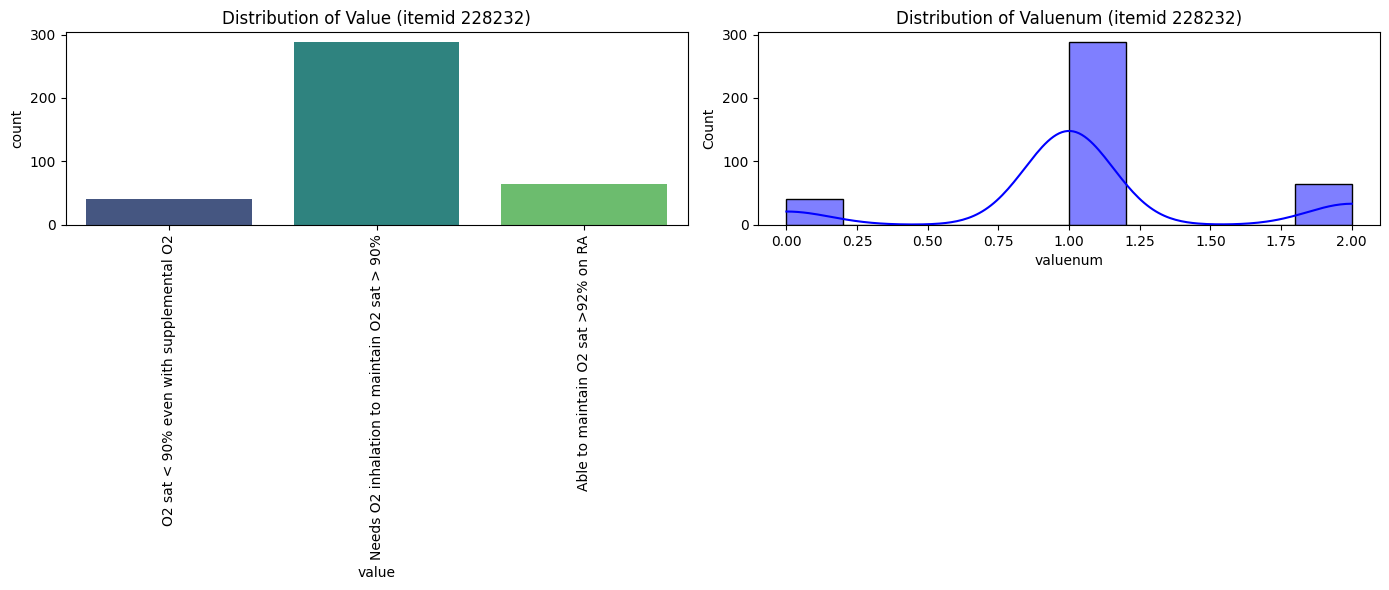

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# itemid가 228232인 row 필터링
filtered_data = chartevents[chartevents['itemid'] == 228232]

# value와 valuenum 분포를 시각화
plt.figure(figsize=(14, 6))

# value 분포 (텍스트 데이터를 제외한 숫자형 데이터만)
plt.subplot(1, 2, 1)
sns.countplot(data=filtered_data, x='value', palette='viridis')
plt.title('Distribution of Value (itemid 228232)')
plt.xticks(rotation=90)  # x축 레이블 회전

# valuenum 분포
plt.subplot(1, 2, 2)
sns.histplot(filtered_data['valuenum'], kde=True, color='blue')
plt.title('Distribution of Valuenum (itemid 228232)')

plt.tight_layout()
plt.show()


- 위중도와 연관도가 높은 itemid 10개를 칼럼으로 선정
- 사망자는 사망시각, 퇴원자는 퇴원시각으로부터의 120 시간 내의 **평균** 심박수, 혈압, 산소 포화도 등을 칼럼에 값으로 삽입

In [162]:
# 필요한 컬럼만 선택
d_items = d_items[['itemid', 'label']]

# 120시간 내 평균값을 계산하는 함수
def add_chartevents_columns_optimized_with_avg(merge_data, filtered_chartevents, d_items, hours=120):
    time_window = pd.Timedelta(hours=hours)
    result = merge_data.copy()

    # 날짜 칼럼을 미리 datetime으로 변환
    filtered_chartevents['charttime'] = pd.to_datetime(filtered_chartevents['charttime'])

    # 각 itemid-label 매핑
    filtered_chartevents = filtered_chartevents.merge(d_items, on='itemid', how='left')

    # 중복된 label을 제거한 고유 label 목록
    unique_labels = filtered_chartevents['label'].dropna().unique()

    # 각 label에 대한 데이터를 merge_data에 추가
    for label in unique_labels:
        # 현재 label에 해당하는 데이터 필터링
        label_data = filtered_chartevents[filtered_chartevents['label'] == label]

        # 각 환자의 평균값 계산
        averages = []
        for idx, row in result.iterrows():
            end_time = pd.to_datetime(row['deathtime'] if row['hospital_expire_flag'] == 1 else row['dischtime'])
            start_time = end_time - time_window

            # 시간 조건과 환자 ID에 해당하는 데이터 필터링
            patient_data = label_data[
                (label_data['hadm_id'] == row['hadm_id']) &
                (label_data['charttime'] >= start_time) &
                (label_data['charttime'] <= end_time)
            ]

            # 등장 빈도로 나누어 평균값 계산
            if len(patient_data) > 0:
                averages.append(patient_data['valuenum'].sum() / len(patient_data))
            else:
                averages.append(0)

        # 결과를 새로운 label 칼럼으로 추가
        result[label] = averages

    return result

In [163]:
# 함수 실행
merge_data = add_chartevents_columns_optimized_with_avg(
    merge_data,
    filtered_chartevents,
    d_items,
    hours=120
)

<ipython-input-162-4512bc49cee7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chartevents['charttime'] = pd.to_datetime(filtered_chartevents['charttime'])


In [164]:
merge_data

,subject_id,hadm_id,admittime,dischtime,deathtime,race,hospital_expire_flag,stay_time,gender,anchor_age,...,Respiratory Rate (spontaneous),Heart Rate,Arterial Blood Pressure mean,Respiratory Rate,Heart rate Alarm - High,Arterial Blood Pressure Alarm - Low,Arterial Blood Pressure Alarm - High,Non Invasive Blood Pressure systolic,Non Invasive Blood Pressure diastolic,PAR-Oxygen saturation
0,10026161,21038524,2133-10-10 11:59:00,2133-10-11 12:23:00,NaN,WHITE,0,24.400000,M,78,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,10026161,24614671,2133-11-11 07:15:00,2133-11-15 18:05:00,2133-11-15 18:05:00,WHITE,1,106.833333,M,78,...,0.0,82.696970,71.584615,19.055118,122.857143,63.571429,104.285714,103.000000,62.750000,0.0
2,10050755,20050796,2134-02-25 18:41:00,2134-02-26 01:26:00,2134-02-26 01:26:00,WHITE - RUSSIAN,1,6.750000,M,77,...,0.0,87.333333,0.000000,35.666667,0.000000,0.000000,0.000000,91.000000,41.000000,0.0
3,10050755,20724333,2134-02-12 23:51:00,2134-02-16 14:38:00,NaN,WHITE - RUSSIAN,0,86.783333,M,77,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,10050755,23782628,2132-10-15 19:02:00,2132-10-19 18:13:00,NaN,WHITE,0,95.183333,M,77,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6392,19991135,29872770,2133-07-04 09:15:00,2133-07-11 18:07:00,NaN,WHITE,0,176.866667,F,57,...,0.0,88.980952,0.000000,21.133333,125.000000,0.000000,0.000000,139.271845,87.116505,0.0
6393,19993336,20406110,2171-11-10 16:50:00,2171-11-14 15:41:00,NaN,WHITE,0,94.850000,F,81,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6394,19993336,22782498,2171-10-24 10:06:00,2171-10-30 14:10:00,NaN,WHITE,0,148.066667,F,81,...,0.0,89.111111,0.000000,15.148148,130.000000,90.000000,160.000000,110.055556,58.277778,0.0
6395,19993336,23077223,2171-09-22 20:24:00,2171-10-04 17:04:00,NaN,WHITE,0,284.666667,F,81,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [165]:
# 결과 확인
print("merge_data에 추가된 label 칼럼들:")
print(merge_data.columns)

merge_data에 추가된 label 칼럼들:
Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'race',
       'hospital_expire_flag', 'stay_time', 'gender', 'anchor_age', 'los',
       'death_within_120hrs', 'patientweight', 'NaCl 0.9%', 'Dextrose 5%',
       'Norepinephrine', 'Solution', 'Phenylephrine', 'Propofol',
       'Epinephrine', 'Insulin - Regular', 'Fentanyl (Concentrate)',
       'Midazolam (Versed)', 'Water', 'IVF ingredient', 'Calories',
       'Blood Ingredient', 'Oral/Gastric Ingredient', 'Calcium (ingr)',
       'Protein', 'Enteral Nutrition Ingredient', 'Carbohydrates',
       'Glucose (ingr)', 'Foley', 'OR EBL', 'Pre-Admission', 'Oral Gastric',
       'Chest Tube #1', 'Chest X-Ray_count', 'EKG_count',
       'Blood Cultured_count', 'Invasive Ventilation_duration',
       'Multi Lumen_duration', 'Arterial Line_duration',
       'Respiratory Rate (spontaneous)', 'Heart Rate',
       'Arterial Blood Pressure mean', 'Respiratory Rate',
       'Heart rate Alarm - High'

In [166]:
# merge_data 데이터프레임을 CSV 파일로 저장(중간저장)
merge_data.to_csv('merge_data_1+2+3+4+5+6+7+8.csv', index=False, encoding='utf-8')

# 전처리 끝 / 이하 모델 학습과 시각화 부분

### Feature Correlation Matrix

In [167]:
merge_data=pd.read_csv('merge_data_1+2+3+4+5+6+7+8.csv') #연결이 끊길 경우에 대비하여 중간저장한 csv파일 불러오기

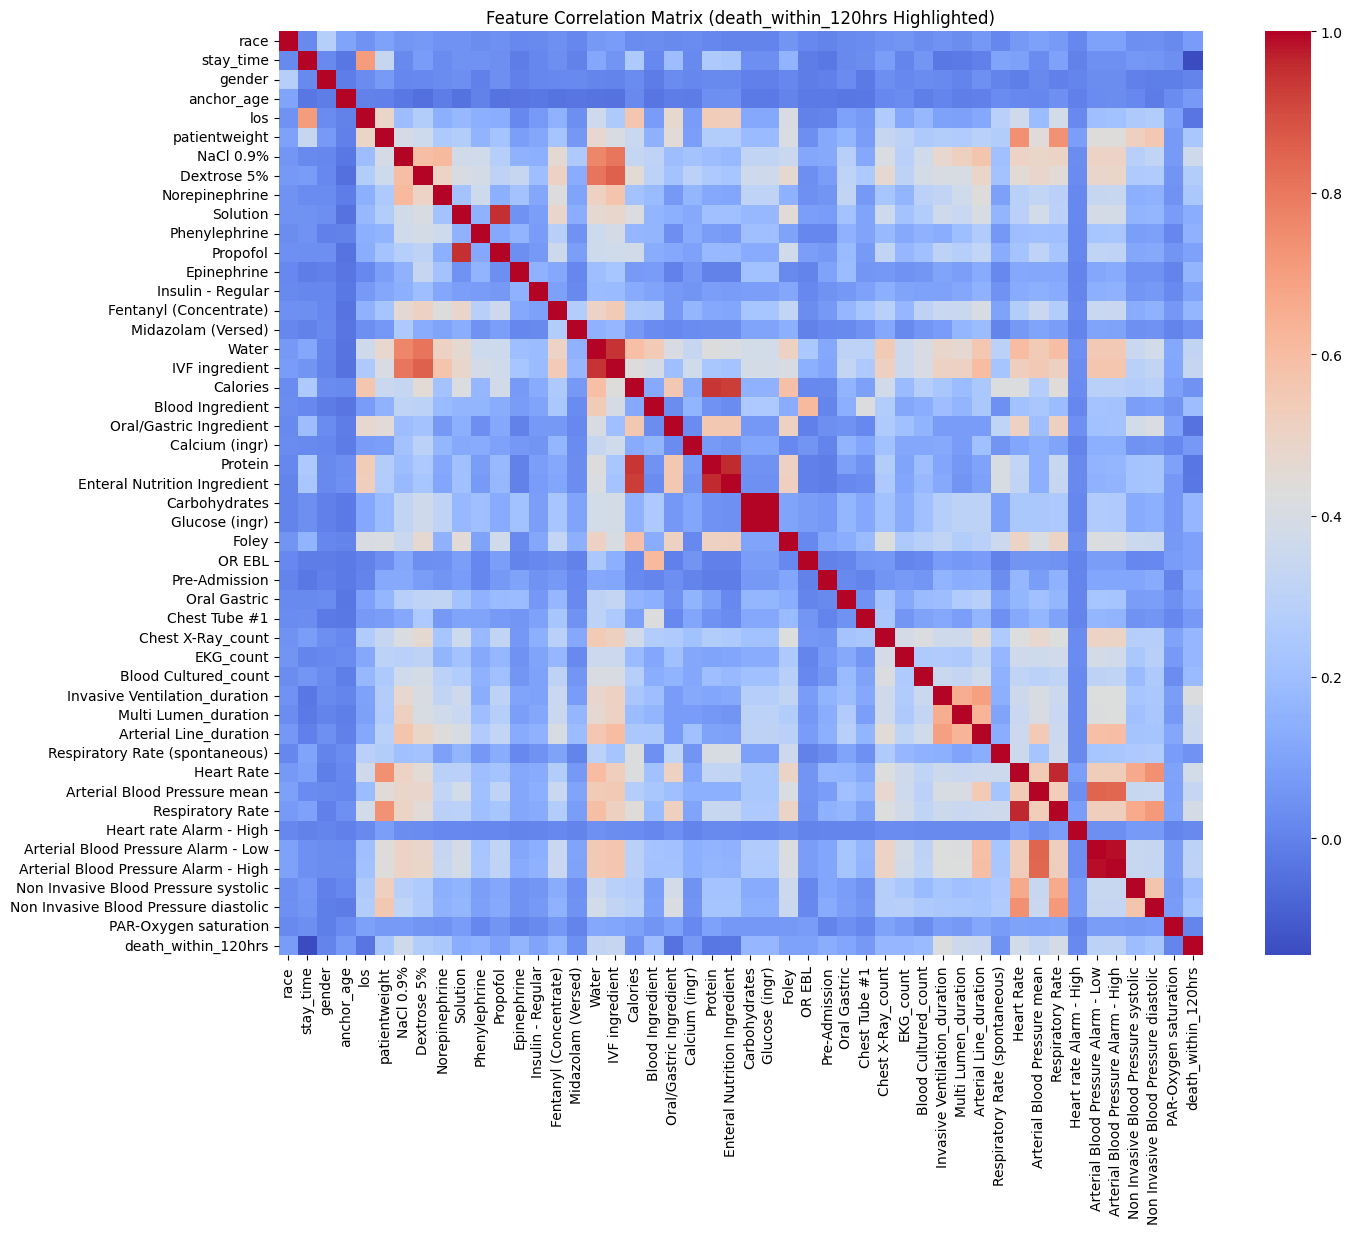

In [168]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 분석에 필요한 칼럼만 선택 ( 필요없는 칼럼 제외 )
feature_columns = [
    col for col in merge_data.columns
    if col not in ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'hospital_expire_flag']
]

# 새로운 데이터프레임 생성
features = merge_data[feature_columns].copy()

# 결측치 처리: 결측치를 0으로 대체
features = features.fillna(0)

# 범주형 변수 인코딩 (gender와 race)
label_encoder = LabelEncoder()
features['gender'] = label_encoder.fit_transform(features['gender'])
features['race'] = label_encoder.fit_transform(features['race'])

# 'death_within_120hrs'를 맨 오른쪽으로 이동
death_column = features.pop('death_within_120hrs')  # 칼럼 추출 후 제거
features['death_within_120hrs'] = death_column      # 맨 오른쪽에 추가

# 상관계수 행렬 계산
correlation_matrix = features.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(16, 12))
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap='coolwarm',
    cbar=True,
    square=True
)
plt.title('Feature Correlation Matrix (death_within_120hrs Highlighted)')
plt.show()


In [169]:
# 타겟 변수와의 상관계수만 추출
target_corr = correlation_matrix['death_within_120hrs'].sort_values(ascending=False)

# 상관관계 출력
print("Feature Correlation with 'death_within_120hrs':")
print(target_corr)

Feature Correlation with 'death_within_120hrs':
death_within_120hrs                      1.000000
Invasive Ventilation_duration            0.420233
Respiratory Rate                         0.387942
Heart Rate                               0.382167
NaCl 0.9%                                0.368472
Multi Lumen_duration                     0.359243
Arterial Line_duration                   0.349473
IVF ingredient                           0.337960
Arterial Blood Pressure mean             0.333300
Water                                    0.316096
Arterial Blood Pressure Alarm - High     0.302303
Arterial Blood Pressure Alarm - Low      0.300423
Dextrose 5%                              0.266618
Norepinephrine                           0.239853
patientweight                            0.238258
Non Invasive Blood Pressure diastolic    0.223565
Blood Ingredient                         0.194266
Non Invasive Blood Pressure systolic     0.191529
Blood Cultured_count                     0.181923
Gl

In [170]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# 분석에 필요한 칼럼만 선택 (제외 칼럼 제거)
feature_columns = [
    col for col in merge_data.columns
    if col not in ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'hospital_expire_flag']
]

# 데이터 준비
features = merge_data[feature_columns].copy()

# 결측치 처리: 결측치를 0으로 대체
features = features.fillna(0)

# 범주형 변수 인코딩 (gender와 race)
label_encoder = LabelEncoder()
features['gender'] = label_encoder.fit_transform(features['gender'])
features['race'] = label_encoder.fit_transform(features['race'])

# 타겟과 피처 분리
X = features.drop(columns=['death_within_120hrs'])
y = features['death_within_120hrs']

# 훈련용/테스트용 데이터 분할 (8:2 비율)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
rf_model = RandomForestClassifier(random_state=42, n_estimators=150,max_depth=15)
rf_model.fit(X_train, y_train)

# 예측
y_pred = rf_model.predict(X_val)

# 평가
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# 중요 피처 출력
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features:")
print(feature_importances.head(10))

import joblib
joblib.dump(rf_model, 'random_forest_model.joblib') #모델 저장

Accuracy: 0.97890625

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1174
           1       0.93      0.80      0.86       106

    accuracy                           0.98      1280
   macro avg       0.96      0.90      0.93      1280
weighted avg       0.98      0.98      0.98      1280


Confusion Matrix:
[[1168    6]
 [  21   85]]

Top Features:
                          Feature  Importance
1                       stay_time    0.207682
34  Invasive Ventilation_duration    0.093416
8                  Norepinephrine    0.069615
4                             los    0.061429
20        Oral/Gastric Ingredient    0.047674
3                      anchor_age    0.043733
35           Multi Lumen_duration    0.042117
36         Arterial Line_duration    0.039698
6                       NaCl 0.9%    0.024372
17                 IVF ingredient    0.023308


['random_forest_model.joblib']

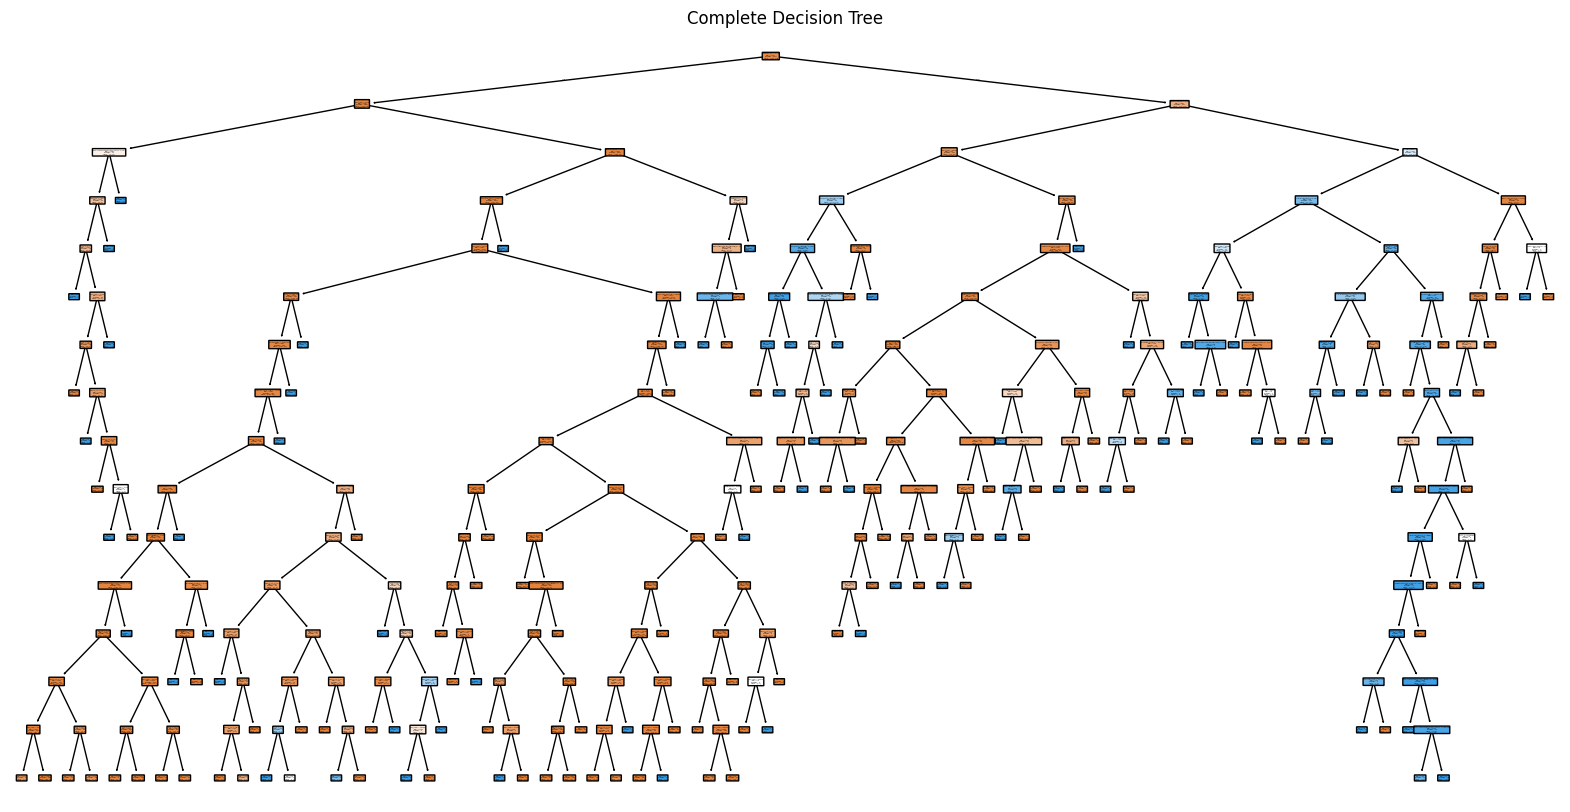

In [171]:
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 랜덤 포레스트에서 첫 번째 트리 선택
single_tree = rf_model.estimators_[0]

# 전체 트리 시각화
plt.figure(figsize=(20, 10))
plot_tree(
    single_tree,
    feature_names=X.columns,
    class_names=['No', 'Yes'],
    filled=True,
    rounded=True
)
plt.title("Complete Decision Tree")
plt.show()


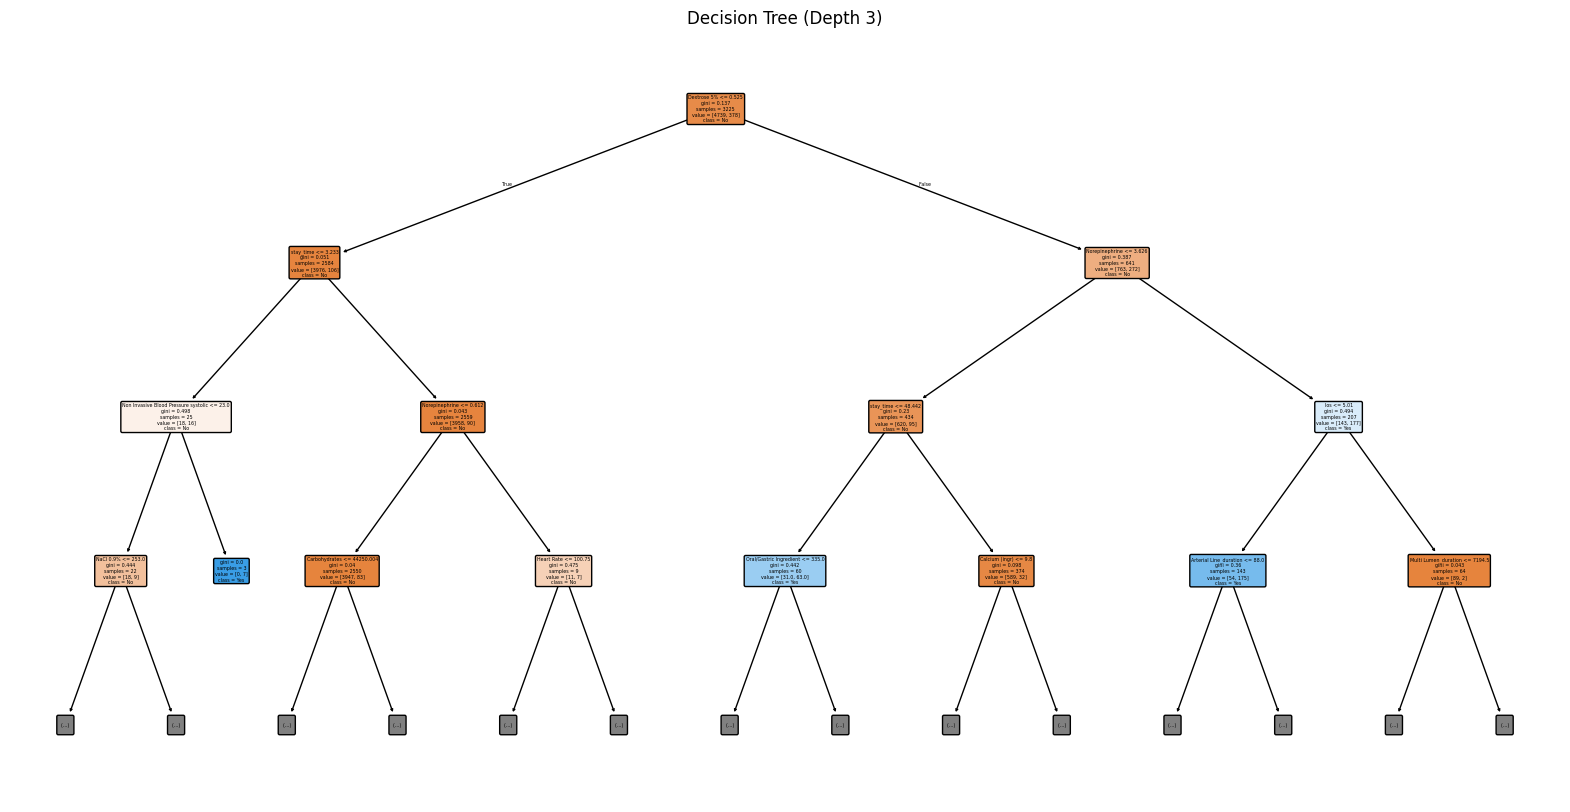

In [172]:
# 깊이를 3으로 제한한 트리 시각화
plt.figure(figsize=(20, 10))
plot_tree(
    single_tree,
    max_depth=3,  # 깊이를 3으로 제한
    feature_names=X.columns,
    class_names=['No', 'Yes'],
    filled=True,
    rounded=True
)
plt.title("Decision Tree (Depth 3)")
plt.show()


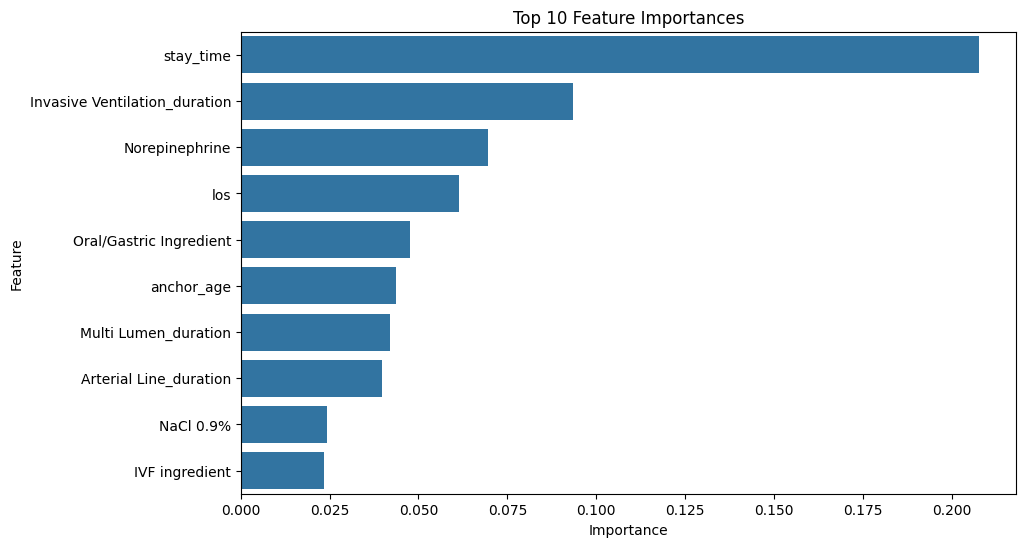

In [173]:
# 중요 피처 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

# 테스트 데이터도 똑같이 전처리하기
(대부분 학습 데이터 전처리때 사용하려고 정의해놓은 함수 사용)

In [174]:
# datetime으로 형식 변환
admissions_test['admittime'] = pd.to_datetime(admissions_test['admittime'])
admissions_test['dischtime'] = pd.to_datetime(admissions_test['dischtime'])
admissions_test['deathtime'] = pd.to_datetime(admissions_test['deathtime'])

# 사망되었다고 판별되었지만, 사망시각이 기록되지 않은 경우 제거
admissions_test = admissions_test[~((admissions_test['hospital_expire_flag'] == 1) & (admissions_test['deathtime'].isna()))]

# 퇴원시각 - 입원시각
admissions_test['stay_time'] = (admissions_test['dischtime'] - admissions_test['admittime']).dt.total_seconds() / 3600
admissions_test = admissions_test[admissions_test['stay_time'] >= 0]

# 퇴원시각과 사망시각이 다른 경우 제거
admissions_test = admissions_test[(admissions_test['dischtime'] == admissions_test['deathtime']) | (admissions_test['dischtime'].isna() | admissions_test['deathtime'].isna())]

# 새롭게 통합할 데이터프레임 생성
merge_data_test = admissions_test
merge_data_test

,subject_id,hadm_id,admittime,dischtime,deathtime,race,hospital_expire_flag,stay_time
0,10010471,21322534,2155-05-08 17:05:00,2155-05-10 18:55:00,NaT,WHITE,0,49.833333
1,10010471,29842315,2155-12-02 19:36:00,2155-12-07 15:30:00,2155-12-07 15:30:00,WHITE,1,115.900000
2,10183369,29493467,2169-03-18 17:13:00,2169-03-19 00:00:00,2169-03-19 00:00:00,UNKNOWN,1,6.783333
3,10199711,26057737,2149-07-05 21:25:00,2149-07-08 19:14:00,NaT,ASIAN - SOUTH EAST ASIAN,0,69.816667
4,10199711,28484415,2149-07-30 22:48:00,2149-07-31 04:32:00,2149-07-31 04:32:00,ASIAN - SOUTH EAST ASIAN,1,5.733333
...,...,...,...,...,...,...,...,...
1395,19965144,23125415,2186-07-25 13:12:00,2186-08-03 16:25:00,NaT,UNKNOWN,0,219.216667
1396,19965144,23909942,2184-03-06 17:16:00,2184-03-15 15:38:00,NaT,PATIENT DECLINED TO ANSWER,0,214.366667
1397,19965144,28838567,2185-04-23 16:01:00,2185-05-01 16:42:00,NaT,PATIENT DECLINED TO ANSWER,0,192.683333
1398,19965144,29536395,2185-12-02 16:17:00,2185-12-07 18:00:00,NaT,PATIENT DECLINED TO ANSWER,0,121.716667


In [175]:
merge_data_test = pd.merge(merge_data_test, patients_test, on='subject_id', how='left')
icustays_test['intime'] = pd.to_datetime(icustays_test['intime'])
icustays_test['outtime'] = pd.to_datetime(icustays_test['outtime'])

# 중환자실에 머무른 시간 합계
icustays_test = icustays_test[['hadm_id','los']]
icustays_sum_test = icustays_test.groupby('hadm_id')['los'].sum().reset_index()

# 통합할 데이터프레임에 추가
merge_data_test = pd.merge(merge_data_test, icustays_sum_test, on='hadm_id', how='left')
merge_data_test['los'] = merge_data_test['los'].fillna(0)
merge_data_test['death_within_120hrs'] = ((merge_data_test['stay_time'] <= 120) & (merge_data_test['hospital_expire_flag'] == 1)).astype(int)


In [176]:
# d_items에서 필요한 컬럼만 선택 (메모리 절약)
d_items = d_items[['itemid', 'label']]

In [177]:
def add_patientweight_column(merge_data, inputevents):
    # patientweight를 추가하기 위한 새로운 칼럼 생성 (초기값은 NaN)
    merge_data['patientweight'] = None

    # inputevents에서 hadm_id를 기준으로 merge_data에 patientweight 추가
    for idx, row in merge_data.iterrows():
        # inputevents에서 해당 hadm_id에 해당하는 patientweight 가져오기
        matching_rows = inputevents[inputevents['hadm_id'] == row['hadm_id']]

        # patientweight가 존재하면 평균값을 넣어줌 (중복된 기록이 있을 수 있음)
        if not matching_rows.empty:
            merge_data.at[idx, 'patientweight'] = matching_rows['patientweight'].mean()

# merge_data에 patientweight 정보 추가
add_patientweight_column(merge_data_test, inputevents_test)

In [178]:
# 단위 통일 기준 정의 (itemid -> 표준 단위)
unit_standardization = {
    222168: 'mg',  # Propofol: mg 단위로 통일
    225942: 'mcg'  # Fentanyl: mcg 단위로 통일
}

# 단위 통일 실행
inputevents_standardized_test = standardize_units(inputevents_test, unit_standardization)

# 결과 확인
print(inputevents_standardized_test[inputevents_standardized_test['itemid'].isin(unit_standardization.keys())])

        subject_id   hadm_id            starttime              endtime  \
340       10329745  20173197  2196-12-06 08:55:00  2196-12-06 17:01:00   
368       10329745  20173197  2196-12-07 10:32:00  2196-12-07 11:00:00   
374       10329745  20173197  2196-12-07 11:00:00  2196-12-07 15:34:00   
389       10329745  20173197  2196-12-07 15:34:00  2196-12-07 17:00:00   
397       10329745  20173197  2196-12-07 16:00:00  2196-12-07 17:14:00   
...            ...       ...                  ...                  ...   
126178    19965144  22781064  2185-09-07 03:27:00  2185-09-07 04:03:00   
126180    19965144  22781064  2185-09-07 04:03:00  2185-09-07 05:03:00   
126184    19965144  22781064  2185-09-07 05:03:00  2185-09-07 05:58:00   
126191    19965144  22781064  2185-09-07 05:58:00  2185-09-07 06:15:00   
126196    19965144  22781064  2185-09-07 06:15:00  2185-09-07 06:59:00   

        itemid       amount amountuom        rate     rateuom  patientweight  
340     225942  2425.000313     

In [179]:
def add_medication_columns_optimized(merge_data_test, inputevents_standardized_test, medications, hours=120):
    time_window = pd.Timedelta(hours=hours)  # 시간 창을 120시간으로 설정
    result = merge_data_test.copy()

    # 날짜 칼럼을 미리 datetime으로 변환
    inputevents_standardized_test['starttime'] = pd.to_datetime(inputevents_standardized_test['starttime'])

    for _, medication in medications.iterrows():
        label = medication['label']
        itemid = medication['itemid']

        # 현재 약물에 대한 데이터만 필터링
        med_data = inputevents_standardized_test[inputevents_standardized_test['itemid'] == itemid]

        # 각 환자의 투약 총량을 계산
        amounts = []
        for idx, row in result.iterrows():
            # 환자의 사망 또는 퇴원 시간을 기준으로 계산 시작/종료 시간 설정
            end_time = pd.to_datetime(row['deathtime'] if row['hospital_expire_flag'] == 1 else row['dischtime'])
            start_time = end_time - time_window

            # 해당 환자의 투약 기록 필터링
            patient_med = med_data[
                (med_data['hadm_id'] == row['hadm_id']) &
                (med_data['starttime'] >= start_time) &
                (med_data['starttime'] <= end_time)
            ]

            # 계산된 약물 투약량을 결과 데이터프레임에 새로운 칼럼으로 추가
            amounts.append(patient_med['amount'].sum())

        result[label] = amounts

    return result


In [180]:
# 함수 실행
merge_data_test = add_medication_columns_optimized(
    merge_data_test,
    inputevents_standardized_test,
    overall_top_medications,
    hours=120
)

In [181]:
def validate_units_for_top10(ingredientevents_test, top10_itemids):
    unit_issues = []  # 단위 불일치 저장용 리스트
    # top10에 해당하는 itemid만 필터링
    filtered_ingredientevents_test = ingredientevents_test[ingredientevents_test['itemid'].isin(top10_itemids)]

    # itemid별로 그룹화하여 단위 확인
    grouped = filtered_ingredientevents_test.groupby('itemid')
    for itemid, group in grouped:
        # 같은 itemid에 대해 고유한 단위 수 확인
        unique_units = group['amountuom'].unique()
        if len(unique_units) > 1:
            unit_issues.append({'itemid': itemid, 'units': unique_units.tolist()})

    return unit_issues

# Top 10 약물의 itemid 리스트 추출
top10_itemids = overall_top_ingredients['itemid'].tolist()

# 단위 불일치 확인 (상위 10개 약물만)
top10_unit_issues = validate_units_for_top10(ingredientevents, top10_itemids)

# 결과 출력
if top10_unit_issues:
    print("단위 불일치가 발견된 상위 10개 ingredients:")
    for issue in top10_unit_issues:
        print(f"itemid: {issue['itemid']}, units: {issue['units']}")
else:
    print("상위 10개 ingredients에서 단위 불일치가 발견되지 않았습니다.")


상위 10개 ingredients에서 단위 불일치가 발견되지 않았습니다.


In [182]:
# 함수 실행
merge_data_test = add_ingredients_columns_optimized(
    merge_data_test,
    ingredientevents_test,
    overall_top_ingredients,
    hours=120
)

In [183]:
# 함수 실행
merge_data_test = add_outputs_columns_optimized(
    merge_data_test,
    outputevents_test,
    overall_top_outputs,
    hours=120
)

In [184]:
merge_data_test = add_procedures_columns_optimized(
    merge_data_test,
    procedureevents_test,
    top_binary,
    top_duration,
    hours=120
)

In [185]:
# 필요한 itemid 리스트
needed_itemids = [
    220045, 220052, 220179, 220180, 220210,
    228232, 220058, 220056, 224689, 220046
]

# 필터링
filtered_chartevents_test = chartevents_test[chartevents_test["itemid"].isin(needed_itemids)]

# 결과 확인
print(filtered_chartevents_test)

         subject_id   hadm_id            charttime  itemid value  valuenum  \
0          10010471  29842315  2155-12-03 22:00:00  220045    79      79.0   
2          10010471  29842315  2155-12-03 22:00:00  220210    12      12.0   
6          10010471  29842315  2155-12-03 22:02:00  220179   100     100.0   
7          10010471  29842315  2155-12-03 22:02:00  220180    49      49.0   
9          10010471  29842315  2155-12-06 07:00:00  220045    69      69.0   
...             ...       ...                  ...     ...   ...       ...   
3903177    19965144  23909942  2184-03-10 05:00:00  220210    17      17.0   
3903180    19965144  23909942  2184-03-10 06:00:00  220045    49      49.0   
3903182    19965144  23909942  2184-03-10 06:00:00  220179   109     109.0   
3903183    19965144  23909942  2184-03-10 06:00:00  220180    44      44.0   
3903185    19965144  23909942  2184-03-10 06:00:00  220210    22      22.0   

         valueuom  
0             bpm  
2        insp/min  
6  

In [186]:
# valueuom의 분포를 itemid별로 확인
uom_distribution = (
    filtered_chartevents_test.groupby(["itemid", "valueuom"])
    .size()
    .reset_index(name="count")
)

# valueuom이 여러 개 있는 itemid 필터링 ( 단위가 다른 경우 )
multiple_uom = uom_distribution["itemid"].duplicated(keep=False)
uom_distribution_with_duplicates = uom_distribution[multiple_uom]

# 결과 출력
print("itemid 가 같은데 단위(valueuom)가 다른 데이터 출력")

print(uom_distribution_with_duplicates)


itemid 가 같은데 단위(valueuom)가 다른 데이터 출력
Empty DataFrame
Columns: [itemid, valueuom, count]
Index: []


In [187]:
# 함수 실행
merge_data_test = add_chartevents_columns_optimized_with_avg(
    merge_data_test,
    filtered_chartevents_test,
    d_items,
    hours=120
)

<ipython-input-162-4512bc49cee7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chartevents['charttime'] = pd.to_datetime(filtered_chartevents['charttime'])


In [188]:
# 결과 확인
print("merge_data_test에 추가된 label 칼럼들:")
print(merge_data_test.columns)

merge_data_test에 추가된 label 칼럼들:
Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'race',
       'hospital_expire_flag', 'stay_time', 'gender', 'anchor_age', 'los',
       'death_within_120hrs', 'patientweight', 'NaCl 0.9%', 'Dextrose 5%',
       'Norepinephrine', 'Solution', 'Phenylephrine', 'Propofol',
       'Epinephrine', 'Insulin - Regular', 'Fentanyl (Concentrate)',
       'Midazolam (Versed)', 'Water', 'IVF ingredient', 'Calories',
       'Blood Ingredient', 'Oral/Gastric Ingredient', 'Calcium (ingr)',
       'Protein', 'Enteral Nutrition Ingredient', 'Carbohydrates',
       'Glucose (ingr)', 'Foley', 'OR EBL', 'Pre-Admission', 'Oral Gastric',
       'Chest Tube #1', 'Chest X-Ray_count', 'EKG_count',
       'Blood Cultured_count', 'Invasive Ventilation_duration',
       'Multi Lumen_duration', 'Arterial Line_duration', 'Heart Rate',
       'Respiratory Rate', 'Non Invasive Blood Pressure systolic',
       'Non Invasive Blood Pressure diastolic', 'Heart rate 

In [189]:
# merge_data 데이터프레임을 CSV 파일로 저장(중간저장)
merge_data_test.to_csv('merge_data_test.csv', index=False, encoding='utf-8')

훈련 데이터에서 사용한 칼럼 순서와 테스트 데이터의 칼럼 순서를 맞추기

In [190]:
train_columns = [
    'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'race',
    'hospital_expire_flag', 'stay_time', 'gender', 'anchor_age', 'los',
    'death_within_120hrs', 'patientweight', 'NaCl 0.9%', 'Dextrose 5%',
    'Norepinephrine', 'Solution', 'Phenylephrine', 'Propofol', 'Epinephrine',
    'Insulin - Regular', 'Fentanyl (Concentrate)', 'Midazolam (Versed)', 'Water',
    'IVF ingredient', 'Calories', 'Blood Ingredient', 'Oral/Gastric Ingredient',
    'Calcium (ingr)', 'Protein', 'Enteral Nutrition Ingredient', 'Carbohydrates',
    'Glucose (ingr)', 'Foley', 'OR EBL', 'Pre-Admission', 'Oral Gastric',
    'Chest Tube #1', 'Chest X-Ray_count', 'EKG_count', 'Blood Cultured_count',
    'Invasive Ventilation_duration', 'Multi Lumen_duration', 'Arterial Line_duration',
    'Respiratory Rate (spontaneous)', 'Heart Rate', 'Arterial Blood Pressure mean',
    'Respiratory Rate', 'Heart rate Alarm - High', 'Arterial Blood Pressure Alarm - Low',
    'Arterial Blood Pressure Alarm - High', 'Non Invasive Blood Pressure systolic',
    'Non Invasive Blood Pressure diastolic', 'PAR-Oxygen saturation'
]

# 테스트 데이터 로드
test_data = pd.read_csv('merge_data_test.csv')

# 테스트 데이터의 칼럼 순서를 훈련 데이터 순서에 맞춤
test_data = test_data[train_columns]

# 순서가 맞춰진 테스트 데이터 확인
print("테스트 데이터 칼럼 순서가 훈련 데이터와 일치합니다.")
print(test_data.columns.tolist())

# 필요시 저장
test_data.to_csv('merge_data_test_sorted.csv', index=False)


테스트 데이터 칼럼 순서가 훈련 데이터와 일치합니다.
['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'race', 'hospital_expire_flag', 'stay_time', 'gender', 'anchor_age', 'los', 'death_within_120hrs', 'patientweight', 'NaCl 0.9%', 'Dextrose 5%', 'Norepinephrine', 'Solution', 'Phenylephrine', 'Propofol', 'Epinephrine', 'Insulin - Regular', 'Fentanyl (Concentrate)', 'Midazolam (Versed)', 'Water', 'IVF ingredient', 'Calories', 'Blood Ingredient', 'Oral/Gastric Ingredient', 'Calcium (ingr)', 'Protein', 'Enteral Nutrition Ingredient', 'Carbohydrates', 'Glucose (ingr)', 'Foley', 'OR EBL', 'Pre-Admission', 'Oral Gastric', 'Chest Tube #1', 'Chest X-Ray_count', 'EKG_count', 'Blood Cultured_count', 'Invasive Ventilation_duration', 'Multi Lumen_duration', 'Arterial Line_duration', 'Respiratory Rate (spontaneous)', 'Heart Rate', 'Arterial Blood Pressure mean', 'Respiratory Rate', 'Heart rate Alarm - High', 'Arterial Blood Pressure Alarm - Low', 'Arterial Blood Pressure Alarm - High', 'Non Invasive Blood 

# 테스트 데이터로 성능 평가

In [191]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

# test 데이터 로드
test_data = pd.read_csv('merge_data_test_sorted.csv')

# 분석에 필요한 칼럼만 선택 (제외 칼럼 제거)
feature_columns = [
    col for col in train_columns
    if col not in ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'hospital_expire_flag']
]

# 데이터 준비 (칼럼 순서 유지)
features = test_data[feature_columns].copy()

# 칼럼 순서 확인 출력
print("사용되는 특성 칼럼 순서:")
print(features.columns.tolist())

# 결측치 처리: 결측치를 0으로 대체
features = features.fillna(0)

# 범주형 변수 인코딩 (gender와 race)
label_encoder = LabelEncoder()
features['gender'] = label_encoder.fit_transform(features['gender'])
features['race'] = label_encoder.fit_transform(features['race'])

# 타겟과 피처 분리
X_test = features.drop(columns=['death_within_120hrs'])
y_test = features['death_within_120hrs']

# 저장된 모델 불러오기
try:
    rf_model = joblib.load('random_forest_model.joblib')
except:
    print("모델 파일을 찾을 수 없습니다. 먼저 모델을 저장해주세요.")
    raise

# 예측 전 특성 순서 검증
print("\n모델 특성 수:", len(rf_model.feature_names_in_))
print("테스트 데이터 특성 수:", len(X_test.columns))
print("\n첫 5개 모델 특성:", rf_model.feature_names_in_[:5])
print("첫 5개 테스트 특성:", X_test.columns[:5])

# 예측
y_pred = rf_model.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Data Evaluation Results:")
print("============================")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 중요 피처 출력
feature_importances = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features:")
print(feature_importances.head(10))

# 예측 확률 계산
y_pred_proba = rf_model.predict_proba(X_test)

# 예측 결과를 DataFrame으로 저장
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred,
    'Probability_Class_1': y_pred_proba[:, 1]
})

# 결과 저장
results_df.to_csv('test_predictions.csv', index=False)
print("\n예측 결과가 'test_predictions.csv' 파일로 저장되었습니다.")

사용되는 특성 칼럼 순서:
['race', 'stay_time', 'gender', 'anchor_age', 'los', 'death_within_120hrs', 'patientweight', 'NaCl 0.9%', 'Dextrose 5%', 'Norepinephrine', 'Solution', 'Phenylephrine', 'Propofol', 'Epinephrine', 'Insulin - Regular', 'Fentanyl (Concentrate)', 'Midazolam (Versed)', 'Water', 'IVF ingredient', 'Calories', 'Blood Ingredient', 'Oral/Gastric Ingredient', 'Calcium (ingr)', 'Protein', 'Enteral Nutrition Ingredient', 'Carbohydrates', 'Glucose (ingr)', 'Foley', 'OR EBL', 'Pre-Admission', 'Oral Gastric', 'Chest Tube #1', 'Chest X-Ray_count', 'EKG_count', 'Blood Cultured_count', 'Invasive Ventilation_duration', 'Multi Lumen_duration', 'Arterial Line_duration', 'Respiratory Rate (spontaneous)', 'Heart Rate', 'Arterial Blood Pressure mean', 'Respiratory Rate', 'Heart rate Alarm - High', 'Arterial Blood Pressure Alarm - Low', 'Arterial Blood Pressure Alarm - High', 'Non Invasive Blood Pressure systolic', 'Non Invasive Blood Pressure diastolic', 'PAR-Oxygen saturation']

모델 특성 수: 47
테스트 

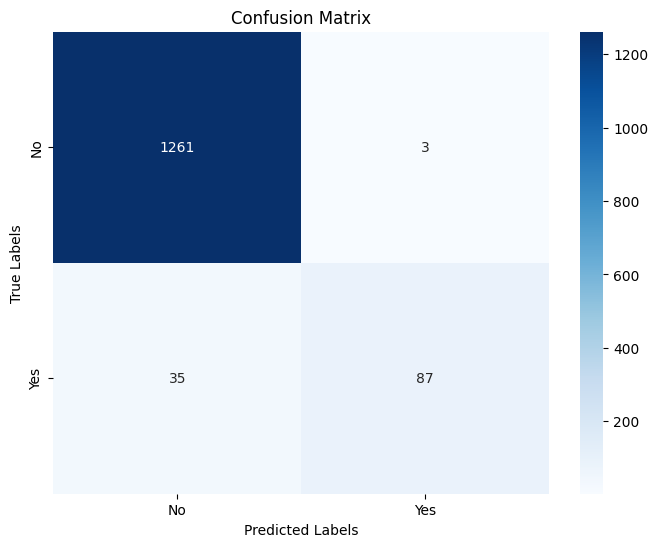

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
